# Fake News Detection Implementation and Experiments
## 1. Introduction
Provide a brief overview of the goals of the experiment and its relevance to your thesis.

---

## 2. Extracting Graph Dataset
### 2.1. Dataset Description
- Provide details about the dataset (e.g., source, structure, and format).

### 2.2. Dataset Loading and Preprocessing
- Describe and implement dataset loading, cleaning, and conversion into graph format.

In [1]:
import sys
sys.path.append('../data')
from dataset import PersianTweet

/home/ag/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# from transformers import BertModel, BertTokenizer
# import torch
# import torch_geometric as pyg
# from tqdm import tqdm

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# bert = BertModel.from_pretrained('bert-base-uncased').to(device)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# pheme = PHEME('../data/pheme', tokenizer=tokenizer, embedder=bert, device=device)
ptdataset = PersianTweet('../data/ptdataset')

### 2.3. Graph Statistics
- Include code to calculate and display statistics (e.g., number of nodes, edges, and types).

---

## 3. Data Splitting
### 3.1. Splitting Strategy
- Describe your strategy for splitting the dataset into training, validation, and test sets.


### 3.2. Implementation
- Implement the splitting process with code.

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
y = []

for data in ptdataset:

    y.append(data.y.item())


data_train, data_test, y_train, y_test = train_test_split(
    ptdataset, y, 
    test_size=2/10, 
    stratify=y, 
    shuffle=True,
    random_state=0
)
data_train, data_val, y_train, y_val = train_test_split(
    data_train, y_train, 
    test_size=1/8, 
    stratify=y_train, 
    shuffle=True,
    random_state=0
)

---

## 4. Data Normalization
### 4.1. Normalization Techniques
- Explain normalization methods applied to node features or edge weights.

### 4.2. Implementation
- Code for normalizing the data.

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

In [6]:
train_tweets = []
train_users  = []

for data in data_train:
    train_tweets.append(data['tweet'].x.numpy())
    train_users.append(data['user'].x.numpy())

train_tweets = np.vstack(train_tweets)
train_users = np.vstack(train_users)

tweet_scaler = StandardScaler()
user_scaler = StandardScaler()
tweet_scaler.fit(train_tweets)
user_scaler.fit(train_users)

StandardScaler()

In [7]:
for data in data_train:
    data['tweet'].x = torch.tensor(
        tweet_scaler.transform(data['tweet'].x), 
        dtype=torch.float32
    )
    data['user'].x = torch.tensor(
        user_scaler.transform(data['user'].x), 
        dtype=torch.float32
    )

for data in data_val:
    data['tweet'].x = torch.tensor(
        tweet_scaler.transform(data['tweet'].x), 
        dtype=torch.float32
    )
    data['user'].x = torch.tensor(
        user_scaler.transform(data['user'].x), 
        dtype=torch.float32
    )

for data in data_test:
    data['tweet'].x = torch.tensor(
        tweet_scaler.transform(data['tweet'].x), 
        dtype=torch.float32
    )
    data['user'].x = torch.tensor(
        user_scaler.transform(data['user'].x), 
        dtype=torch.float32
    )

---

## 5. Self-Supervised Phase
### 5.1. Model Architecture
- Define the base models, including MLP and GNN classes.

### 5.2. Loss Function
- Describe the self-supervised loss function and its purpose.

In [8]:
import torch.nn.functional as F

In [9]:
def masked_node_reconstruction_loss(embeddings, original_features, mask):

    loss = F.mse_loss(
        embeddings[mask], 
        original_features[mask]
    )

    if torch.isnan(loss).any():
        return torch.tensor(0)

    return loss

def node_reconstruction_loss(embeddings, original_features):

    return F.mse_loss(
        embeddings, 
        original_features
    )

def triplet_loss(e_anchor, e_pos, e_neg, margin=1.0):

    # Normalize embeddings to stabilize training
    e_anchor = F.normalize(e_anchor, p=2, dim=-1)
    e_pos    = F.normalize(e_pos, p=2, dim=-1)
    e_neg    = F.normalize(e_neg, p=2, dim=-1)
    
    loss = F.triplet_margin_loss(
        anchor=e_anchor, 
        positive=e_pos, 
        negative=e_neg, 
        margin=margin, 
        p=2
    )
    return loss

### 5.3. Extracting Self-Supervised Data
- Code for extracting data for self-supervised training at each epoch.

In [10]:
import torch_geometric as pyg
import random

In [11]:
def add_cls_node(data, as_node_type: str='tweet'):

    nodes = []
    for edge_type in data.edge_types:
        
        if as_node_type not in edge_type:
            continue

        if edge_type[0] == as_node_type and edge_type[2] == as_node_type:
            nodes += data[edge_type].edge_index.flatten().tolist()
        elif edge_type[0] == as_node_type:
            nodes += data[edge_type].edge_index[0, :].tolist()
        else:
            nodes += data[edge_type].edge_index[1, :].tolist()
    
    nodes = set(nodes)

    new_edges = torch.tensor(
        [[node, 0] for node in nodes]
    ).t()

    data['cls'].x = data[as_node_type].x[list(nodes)].mean(dim=0).unsqueeze(dim=0)
    data[as_node_type, 'agg', 'cls'].edge_index = new_edges

In [12]:
def mask_node(
    x_dict: dict,
    masking_prob: float=0.15, 
    random_prob: float=0.1, 
    unchanged_prob: float=0.1, 
    mask_token: float=1.0
):

    # Deep copy
    masked_x_dict = {node_type: x.clone() for node_type, x in x_dict.items()}
    mask_dict = {}

    for node_type, x in masked_x_dict.items():

        # if node_type == 'cls':
        #     continue
        if node_type != 'tweet':
            continue

        # Overall mask: Select 15% of tokens for prediction
        full_mask = torch.rand(x.shape[0]) < masking_prob

        # Randomly mask some of these tokens (10% of 15%)
        random_mask = full_mask & (torch.rand(x.shape[0]) < random_prob)

        # Keep some unchanged (10% of 15%)
        unchanged_mask = full_mask & (torch.rand(x.shape[0]) < unchanged_prob)

        # Mask the remaining (80% of 15%) with [MASK]
        mask_mask = full_mask & (~random_mask) & (~unchanged_mask)


        # Modify the original x tensor
        # Replace with random token
        x[random_mask] = torch.rand_like(x[random_mask])
        # Replace with [MASK]
        x[mask_mask] = mask_token
        # Unchanged_mask already preserves the original values, no action required
        
        # Update the dictionary
        masked_x_dict[node_type] = x
        mask_dict[node_type] = mask_mask 
    
    return masked_x_dict, mask_dict

In [13]:
def self_supervised_phase(batch, batch_size: int=8):

    anchor_datas = []
    pos_datas = []
    neg_datas = []

    for i, conversation_thead in enumerate(batch[:]):

        # ramdomly sample 2 segments from the thread
        total_timesteps = conversation_thead.timesteps.item()
        if total_timesteps > 1:
            t1, t2 = sorted(
                random.sample(range(total_timesteps), 2)
            )
        else:
            t1, t2 = 0, 0
        while True:
            j = random.randint(0, len(batch) - 1)
            if i != j and batch[j].y != conversation_thead.y:
                break

        data_anchor = conversation_thead.clone()
        data_pos = conversation_thead.clone()
        data_neg = batch[j].clone()

        t3 = random.randint(0, data_neg.timesteps.item())

        for edge_type in conversation_thead.edge_types:
            mask = data_anchor[edge_type].time <= t1
            data_anchor[edge_type].edge_index = data_anchor[edge_type].edge_index[:, mask]

            mask = data_pos[edge_type].time <= t2
            data_pos[edge_type].edge_index = data_pos[edge_type].edge_index[:, mask]

            mask = data_neg[edge_type].time <= t3
            data_neg[edge_type].edge_index = data_neg[edge_type].edge_index[:, mask]


        # Link cls node with all tweet nodes at the current step
        add_cls_node(
            data=data_anchor, 
            as_node_type='tweet'
        )
        add_cls_node(
            data=data_pos, 
            as_node_type='tweet'
        )
        add_cls_node(
            data=data_neg, 
            as_node_type='tweet'
        )


        anchor_datas.append(data_anchor)
        pos_datas.append(data_pos)
        neg_datas.append(data_neg)

    anchor_loader = pyg.loader.DataLoader(
        anchor_datas, 
        batch_size=batch_size, 
        shuffle=False
    )
    pos_loader = pyg.loader.DataLoader(
        pos_datas, 
        batch_size=batch_size, 
        shuffle=False
    )
    neg_loader = pyg.loader.DataLoader(
        neg_datas, 
        batch_size=batch_size, 
        shuffle=False
    )

    return anchor_loader, pos_loader, neg_loader

### 5.4. Model
- Implement the pretraining phase and discuss its goals.

In [14]:
from models import MLP

import numpy as np
from collections import defaultdict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os

/home/ag/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [15]:
def visualize_embeddings(E_train, y_train, E_val, y_val, epoch):

    pca = PCA(n_components=2)
    z_train = pca.fit_transform(np.concatenate(E_train))

    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid", context="notebook")

    color_map = {1: 'red', 0: 'green'}

    unique_classes_train = np.unique(np.concatenate(y_train))
    class_labels_train = {cls: f"Class {cls}" for cls in unique_classes_train}

    plt.subplot(1, 2, 1)
    for cls in unique_classes_train:
        indices = np.concatenate(y_train) == cls
        plt.scatter(
            z_train[indices, 0],
            z_train[indices, 1],
            label=class_labels_train[cls],
            alpha=0.6,
            edgecolor='k',
            color=color_map[cls]
        )
    plt.title(f"Training Data")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(loc="best")

    if E_val is not None and y_val is not None:
        z_val = pca.transform(np.concatenate(E_val))
        unique_classes_val = np.unique(np.concatenate(y_val))
        class_labels_val = {cls: f"Class {cls}" for cls in unique_classes_val}

        plt.subplot(1, 2, 2)
        for cls in unique_classes_val:
            indices = np.concatenate(y_val) == cls
            plt.scatter(
                z_val[indices, 0],
                z_val[indices, 1],
                label=class_labels_val[cls],
                alpha=0.6,
                edgecolor='k',
                color=color_map[cls]
            )
        plt.title(f"Validation Data")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.legend(loc="best")

    plt.tight_layout()

    output_path = os.path.join('output', f"epoch_{epoch}.png")

    plt.savefig(output_path, dpi=300)
    plt.close()

In [16]:
def plot_thread_over_time(datas, model, selected_indices):

    label_groups = defaultdict(list)
    for i, data in enumerate(datas):
        if data.timesteps.item() > 1:
            label_groups[data.y.item()].append(i)

    min_group_size = min(len(indices) for indices in label_groups.values())
    sample_size = min(min_group_size, 10 // len(label_groups))

    # selected_indices = []
    # for label, indices in label_groups.items():
    #     selected_indices.extend(random.sample(indices, sample_size))

    random.shuffle(selected_indices)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, ax in zip(selected_indices, axes):
        temp = []
        data = datas[idx]
        for i in range(data.timesteps.item()):
            d = data.clone()
            for edge_type in d.edge_types:
                mask = d[edge_type].time <= i
                d[edge_type].edge_index = d[edge_type].edge_index[:, mask]
            temp.append(d)

        pca = PCA(n_components=2)
        z = pca.fit_transform(model(temp)['cls'].cpu().detach())

        timesteps = np.arange(len(temp))

        scatter = ax.scatter(
            z[:, 0], z[:, 1],
            c=timesteps,
            cmap='viridis',
            s=100,
            edgecolor='k',
            alpha=0.8,
            label=f"Label: {data.y.item()}"
        )

        # ax.legend(loc='upper right', fontsize=10)


        ax.set_title(f'Conversation {idx}', fontsize=14)
        ax.set_xlabel('PCA Component 1', fontsize=10)
        ax.set_ylabel('PCA Component 2', fontsize=10)
        ax.grid(alpha=0.3)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Timesteps', fontsize=10)

    plt.suptitle('PCA Embedding of Conversation Threads Over Time', fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [17]:
def plot_thread_over_time(datas, model, selected_indices):
    import random
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from collections import defaultdict

    label_groups = defaultdict(list)
    for i, data in enumerate(datas):
        if data.timesteps.item() > 1:
            label_groups[data.y.item()].append(i)

    min_group_size = min(len(indices) for indices in label_groups.values())
    sample_size = min(min_group_size, 10 // len(label_groups))

    random.shuffle(selected_indices)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    scatter_plots = []
    for idx, ax in zip(selected_indices, axes):
        temp = []
        data = datas[idx]
        for i in range(data.timesteps.item()):
            d = data.clone()
            for edge_type in d.edge_types:
                mask = d[edge_type].time <= i
                d[edge_type].edge_index = d[edge_type].edge_index[:, mask]
            temp.append(d)

        pca = PCA(n_components=2)
        z = pca.fit_transform(model(temp)['cls'].cpu().detach())

        timesteps = np.arange(len(temp))

        scatter = ax.scatter(
            z[:, 0], z[:, 1],
            c=timesteps,
            cmap='viridis',
            s=100,
            edgecolor='k',
            alpha=0.8,
            label=f"Label: {data.y.item()}"
        )
        scatter_plots.append(scatter)

        ax.set_title(f'Conversation {idx}', fontsize=14)
        ax.set_xlabel('PCA Component 1', fontsize=10)
        ax.set_ylabel('PCA Component 2', fontsize=10)
        ax.grid(alpha=0.3)

    # Add a single color bar to the right of the entire figure
    cbar = fig.colorbar(scatter_plots[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.05)
    cbar.set_label('Timesteps', fontsize=12)

    # plt.suptitle('PCA Embedding of Conversation Threads Over Time', fontsize=24)
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to make space for the color bar
    plt.show()


In [18]:
962 1065 704 955 360 796 1156 705 1141 718 541

SyntaxError: invalid syntax (2422770138.py, line 1)

In [19]:
360 1156 705 1141 718 541

SyntaxError: invalid syntax (418389514.py, line 1)

/tmp/ipykernel_10156/4050403375.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to make space for the color bar


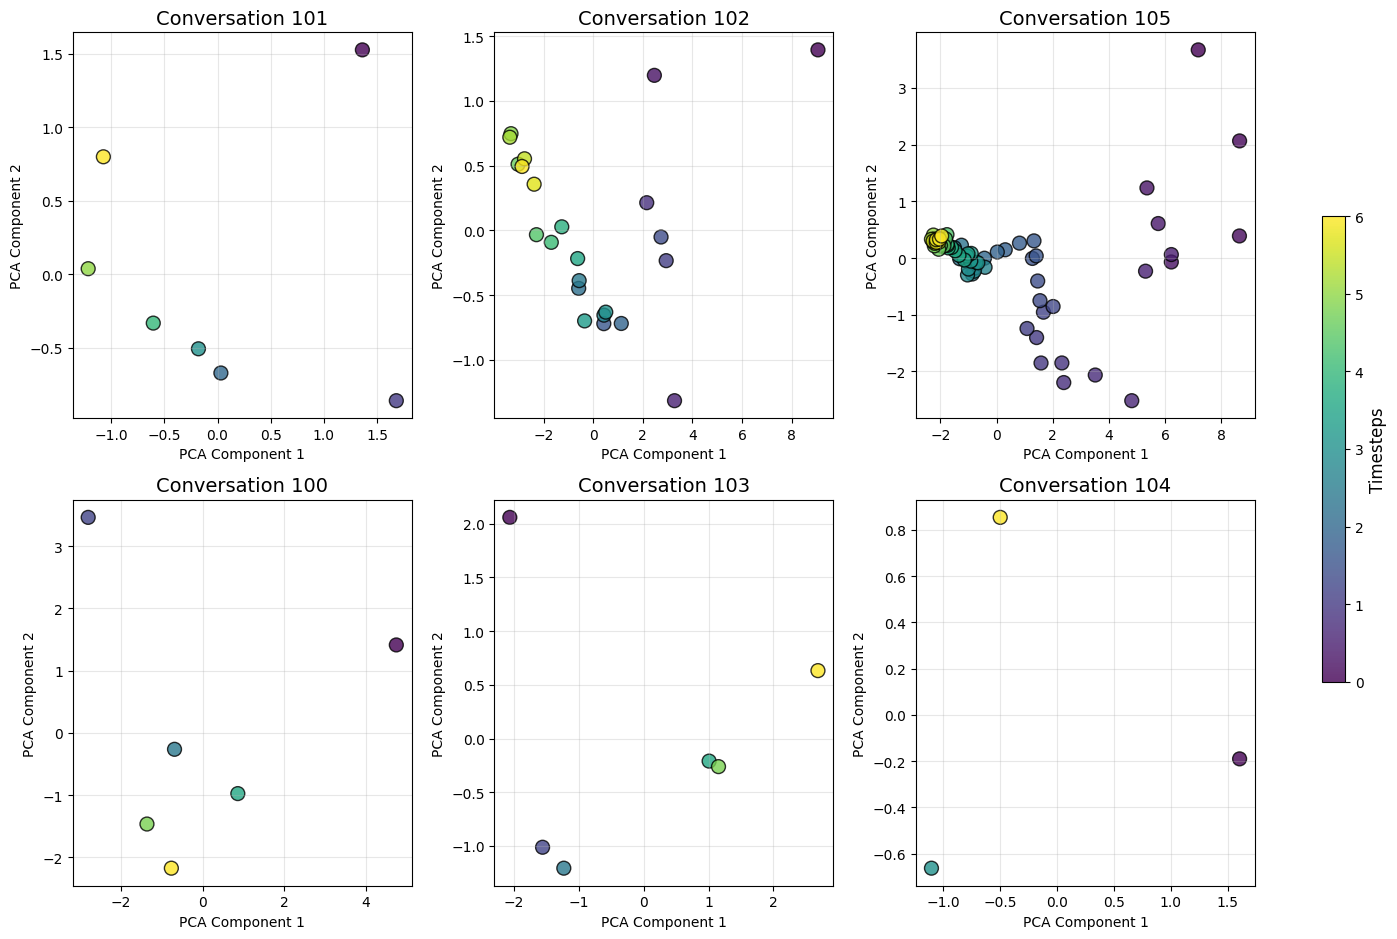

In [27]:
plot_thread_over_time(data_test, ttn, [100, 101, 102, 103, 104, 105])

In [18]:
class TemporalEncoding(torch.nn.Module):
    def __init__(self, dimension: int, max_time: int = 5000, device=torch.device('cpu')):

        super(TemporalEncoding, self).__init__()
        self.dimension = dimension

        # Create constant frequency terms for encoding
        self.inv_freq = 1.0 / (max_time ** (torch.arange(0, dimension, 2, device=device).float() / dimension))
    
    def forward(self, times: torch.Tensor) -> torch.Tensor:

        # Expand times to match the frequency terms
        times = times.unsqueeze(1).to(times.device)      # Shape: (N, 1)
        angles = times * self.inv_freq                   # Shape: (N, D/2)

        encoding = torch.zeros(
            (times.size(0), self.dimension), 
            device=times.device
        )
        encoding[:, 0::2] = torch.sin(angles)
        encoding[:, 1::2] = torch.cos(angles)

        return encoding

In [19]:
class TimeThreadNet(torch.nn.Module):

    def __init__(self, gnn, decoder, device, dimension: int=32):

        super(TimeThreadNet, self).__init__()

        self.CLS        = torch.nn.Parameter(
            torch.randn(1, dimension)
        )
        self.GNN        = gnn
        self.DECODER    = decoder

        self.TE = TemporalEncoding(dimension=770, device=device)

        self.device = device
    
    def compile(self, optimizer, loss, lr: float=0.0005):

        self.optimizer = optimizer(
            self.parameters(),
            lr=lr
        )
        self.loss = loss

        self.history = {
            'loss_train': [],
            'loss_con_train': [],
            'loss_rec_train': [],
            'loss_validation': [],
            'loss_con_validation': [],
            'loss_rec_validation': [],
        }

    def forward(self, data):

        datas = [data[i] for i in range(len(data))]
        for d in datas:
            add_cls_node(d)
        batch = pyg.data.Batch.from_data_list(datas).to(self.device)

        x_dict = batch.x_dict
        edge_index_dict = batch.edge_index_dict

        # Apply temporal encoding to the node features

        # temporal_features = self.TemporalEncoding(
        #     torch.arange(batch['tweet'].x.size(0), device=self.device)
        # )
        # x_dict['tweet'] += temporal_features

        e = self.GNN(x_dict, edge_index_dict)

        return e

    def pretrain_step(self, data):

        self.train()
        self.optimizer.zero_grad()

        L_REC = 0
        L_CON = 0

        anchor_loader, pos_loader, neg_loader = self_supervised_phase(
            batch=data, batch_size=8
        )

        n = 0
        for anchor_batch, pos_batch, neg_batch in zip(anchor_loader, pos_loader, neg_loader):

            anchor_batch = anchor_batch.to(self.device)
            pos_batch = pos_batch.to(self.device)
            neg_batch = neg_batch.to(self.device)

            anchor_x_dict = anchor_batch.x_dict
            anchor_masked_x_dict, anchor_mask = mask_node(x_dict=anchor_x_dict)
            anchor_edge_index_dict = anchor_batch.edge_index_dict
            for node_type in anchor_batch.node_types:

                if node_type == 'cls':
                    continue

                _, counts = torch.unique(anchor_batch[node_type].batch, return_counts=True)
                timesteps = torch.cat([torch.arange(count) for count in counts]).to(self.device)

                temporal_features = self.TE(timesteps)
                anchor_x_dict[node_type][:, :770] += temporal_features

            pos_x_dict = pos_batch.x_dict
            pos_masked_x_dict, pos_mask = mask_node(x_dict=pos_x_dict)
            pos_edge_index_dict = pos_batch.edge_index_dict
            for node_type in pos_batch.node_types:

                if node_type == 'cls':
                    continue
    
                _, counts = torch.unique(pos_batch[node_type].batch, return_counts=True)
                timesteps = torch.cat([torch.arange(count) for count in counts]).to(self.device)

                temporal_features = self.TE(timesteps)
                pos_x_dict[node_type][:, :770] += temporal_features

            neg_x_dict = neg_batch.x_dict
            neg_masked_x_dict, neg_mask = mask_node(x_dict=neg_x_dict)
            neg_edge_index_dict = neg_batch.edge_index_dict
            for node_type in neg_batch.node_types:

                if node_type == 'cls':
                    continue
    
                _, counts = torch.unique(neg_batch[node_type].batch, return_counts=True)
                timesteps = torch.cat([torch.arange(count) for count in counts]).to(self.device)

                temporal_features = self.TE(timesteps)
                neg_x_dict[node_type][:, :770] += temporal_features

            e_anchor = self.GNN(anchor_masked_x_dict, anchor_edge_index_dict)
            e_pos = self.GNN(pos_masked_x_dict, pos_edge_index_dict)
            e_neg = self.GNN(neg_masked_x_dict, neg_edge_index_dict)

            L_CON += triplet_loss(e_anchor=e_anchor['cls'], e_pos=e_pos['cls'], e_neg=e_neg['cls'], margin=10.0)

            d_anchor = self.DECODER(e_anchor['tweet'])
            d_pos = self.DECODER(e_pos['tweet'])
            d_neg = self.DECODER(e_neg['tweet'])

            L_REC += masked_node_reconstruction_loss(d_anchor, anchor_x_dict['tweet'], anchor_mask['tweet'])
            L_REC += masked_node_reconstruction_loss(d_pos, pos_x_dict['tweet'], pos_mask['tweet'])
            L_REC += masked_node_reconstruction_loss(d_neg, neg_x_dict['tweet'], neg_mask['tweet'])

            n += len(anchor_batch)

        loss =  L_CON + L_REC

        loss.backward()
        self.optimizer.step()
        
        return loss.item() / n, L_REC / n, L_CON / n
            

    def pretest_step(self, data):

        self.eval()

        L_REC = 0
        L_CON = 0

        anchor_loader, pos_loader, neg_loader = self_supervised_phase(
            batch=data, batch_size=8
        )
        n = 0
        with torch.no_grad():
            for anchor_batch, pos_batch, neg_batch in zip(anchor_loader, pos_loader, neg_loader):

                anchor_batch = anchor_batch.to(self.device)
                pos_batch = pos_batch.to(self.device)
                neg_batch = neg_batch.to(self.device)

                anchor_x_dict = anchor_batch.x_dict
                anchor_masked_x_dict, anchor_mask = mask_node(x_dict=anchor_x_dict)
                anchor_edge_index_dict = anchor_batch.edge_index_dict
                for node_type in anchor_batch.node_types:

                    if node_type == 'cls':
                        continue
        
                    _, counts = torch.unique(anchor_batch[node_type].batch, return_counts=True)
                    timesteps = torch.cat([torch.arange(count) for count in counts]).to(self.device)

                    temporal_features = self.TE(timesteps)
                    anchor_x_dict[node_type][:, :770] += temporal_features

                pos_x_dict = pos_batch.x_dict
                pos_masked_x_dict, pos_mask = mask_node(x_dict=pos_x_dict)
                pos_edge_index_dict = pos_batch.edge_index_dict
                for node_type in pos_batch.node_types:

                    if node_type == 'cls':
                        continue
        
                    _, counts = torch.unique(pos_batch[node_type].batch, return_counts=True)
                    timesteps = torch.cat([torch.arange(count) for count in counts]).to(self.device)

                    temporal_features = self.TE(timesteps)
                    pos_x_dict[node_type][:, :770] += temporal_features

                neg_x_dict = neg_batch.x_dict
                neg_masked_x_dict, neg_mask = mask_node(x_dict=neg_x_dict)
                neg_edge_index_dict = neg_batch.edge_index_dict
                for node_type in neg_batch.node_types:

                    if node_type == 'cls':
                        continue
        
                    _, counts = torch.unique(neg_batch[node_type].batch, return_counts=True)
                    timesteps = torch.cat([torch.arange(count) for count in counts]).to(self.device)

                    temporal_features = self.TE(timesteps)
                    neg_x_dict[node_type][:, :770] += temporal_features

                e_anchor = self.GNN(anchor_masked_x_dict, anchor_edge_index_dict)
                e_pos = self.GNN(pos_masked_x_dict, pos_edge_index_dict)
                e_neg = self.GNN(neg_masked_x_dict, neg_edge_index_dict)

                L_CON += triplet_loss(e_anchor=e_anchor['cls'], e_pos=e_pos['cls'], e_neg=e_neg['cls'], margin=10.0)

                d_anchor = self.DECODER(e_anchor['tweet'])
                d_pos = self.DECODER(e_pos['tweet'])
                d_neg = self.DECODER(e_neg['tweet'])

                L_REC += masked_node_reconstruction_loss(d_anchor, anchor_x_dict['tweet'], anchor_mask['tweet'])
                L_REC += masked_node_reconstruction_loss(d_pos, pos_x_dict['tweet'], pos_mask['tweet'])
                L_REC += masked_node_reconstruction_loss(d_neg, neg_x_dict['tweet'], neg_mask['tweet'])

                n += len(anchor_batch)

        loss = L_CON + L_REC

        return loss.item() / n, L_REC / n, L_CON / n

    def pretrain(self, data_train, data_validation=None, epochs: int=1000, batch_size: int=32, verbose: bool=False):

        if verbose:

            if not os.path.exists('output'):
                os.makedirs('output')

        train_loader = pyg.loader.DataLoader(
            data_train, 
            batch_size=batch_size, 
            shuffle=True
        )

        if data_validation:

            val_loader = pyg.loader.DataLoader(
                data_validation, 
                batch_size=batch_size,
                shuffle=True
            )

        for epoch in range(epochs):

            train_loss, train_loss_rec, train_loss_con = 0, 0, 0
            E_train = []
            y_train = []
            progbar = tqdm(train_loader, desc='')

            for batch_idx, batch in enumerate(progbar):

                loss, loss_rec, loss_con = self.pretrain_step(data=batch)
                train_loss += loss
                train_loss_rec += loss_rec
                train_loss_con += loss_con

                if verbose:

                    e = self(batch)
                    E_train.append(e['cls'].cpu().detach().numpy())
                    y_train.append(batch.y.cpu().detach().numpy())

                log = 'PRETRAINING - Epoch {:03d}/{} - Training Loss: {:.4f} - Loss REC: {:.4f} - Loss CON: {:.4f} '.format(
                    epoch + 1,
                    epochs,
                    train_loss / (batch_idx + 1),
                    train_loss_rec / (batch_idx + 1),
                    train_loss_con / (batch_idx + 1)
                )

                progbar.set_description(log)
            
            self.history['loss_train'].append(train_loss / len(train_loader))
            self.history['loss_con_train'].append(train_loss_con / len(train_loader))
            self.history['loss_rec_train'].append(train_loss_rec / len(train_loader))
            
            if data_validation:

                val_loss, val_loss_rec, val_loss_con = 0, 0, 0
                E_val = []
                y_val = []

                for batch_idx, batch in enumerate(val_loader):

                    loss, loss_rec, loss_con = self.pretest_step(data=batch)
                    val_loss += loss
                    val_loss_rec += loss_rec
                    val_loss_con += loss_con
                
                    if verbose:

                        e = self(batch)
                        E_val.append(e['cls'].cpu().detach().numpy())
                        y_val.append(batch.y.cpu().detach().numpy())
                
                log_val = '                            Val      Loss : {:.4f} - Loss REC: {:.4f} - Loss CON: {:.4f} '.format(
                    val_loss / (batch_idx + 1),
                    val_loss_rec / (batch_idx + 1),
                    val_loss_con / (batch_idx + 1)
                )

                print(log_val)
                print(120 * '=')

                # update history
                self.history['loss_validation'].append(val_loss / len(val_loader))

            if verbose:

                visualize_embeddings(
                    E_train, 
                    y_train, 
                    E_val, 
                    y_val if data_validation else None,
                    epoch=epoch
                )

### 5.4. Pretraining
- Implement the pretraining phase and discuss its goals.


In [20]:
class GNN(torch.nn.Module):

    def __init__(
        self,
        layers: list[torch.nn.Module],
        edge_types: list,
        aggr: str='sum',
    ):

        super(GNN, self).__init__()

        self.convs = torch.nn.ModuleList(
            [
                pyg.nn.HeteroConv(
                    {
                        edge_type: pyg.nn.GATConv(in_channels, h_channels, add_self_loops=False) if edge_type == ('tweet', 'agg', 'cls') else conv(
                            in_channels,
                            h_channels
                        )
                        for edge_type in edge_types
                    },
                    aggr=aggr
                )
		        for conv, in_channels, h_channels in layers
            ]
        )

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(
        self,
        x_dict,
        edge_index_dict
    ):

        for conv in self.convs[:-1]:

            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {
                key: torch.nn.functional.elu(self.dropout(x)) for key, x in x_dict.items()
            }
        x_dict = self.convs[-1](x_dict, edge_index_dict)
        return x_dict

In [21]:
device = torch.device('cuda')
gnn = GNN(
    [
        (pyg.nn.SAGEConv, (-1, -1), 96),
        (pyg.nn.SAGEConv, 96, 64),
        (pyg.nn.SAGEConv, 64, 20),
    ],
    pheme[0].edge_types + [('tweet', 'agg', 'cls')],
    aggr='sum',
).to(device)
decoder = MLP(
    [
        pyg.nn.Linear(20, 1024),
        torch.nn.SiLU(),
        pyg.nn.Linear(1024, 1024),
        torch.nn.SiLU(),
        pyg.nn.Linear(1024, 512),
        torch.nn.SiLU(),
        pyg.nn.Linear(512, 512),
        torch.nn.SiLU(),
        pyg.nn.Linear(512, pheme[0]['tweet'].x.size(1))
    ],
    device=device,
    activation=torch.nn.Softmax()
)

ttn = TimeThreadNet(
    gnn=gnn, decoder=decoder, device=device
)
ttn.compile(
    optimizer=torch.optim.Adam, 
    loss=torch.nn.CrossEntropyLoss(),
    lr=0.0001
)

NameError: name 'pheme' is not defined

In [20]:
device

device(type='cuda')

In [21]:
ttn.pretrain(
    data_train=data_train, 
    data_validation=data_val, 
    batch_size=256, 
    epochs=10, 
    verbose=True
)

PRETRAINING - Epoch 001/10 - Training Loss: 1.7394 - Loss REC: 0.5342 - Loss CON: 1.2051 : 100%|██████████| 18/18 [00:40<00:00,  2.24s/it]


                            Val      Loss : 1.6849 - Loss REC: 0.4961 - Loss CON: 1.1887 


PRETRAINING - Epoch 002/10 - Training Loss: 1.6514 - Loss REC: 0.4606 - Loss CON: 1.1908 : 100%|██████████| 18/18 [00:40<00:00,  2.25s/it]


                            Val      Loss : 1.6320 - Loss REC: 0.4531 - Loss CON: 1.1789 


PRETRAINING - Epoch 003/10 - Training Loss: 1.6208 - Loss REC: 0.4384 - Loss CON: 1.1824 : 100%|██████████| 18/18 [00:41<00:00,  2.32s/it]


                            Val      Loss : 1.5896 - Loss REC: 0.4213 - Loss CON: 1.1684 


PRETRAINING - Epoch 004/10 - Training Loss: 1.6176 - Loss REC: 0.4413 - Loss CON: 1.1763 : 100%|██████████| 18/18 [00:41<00:00,  2.32s/it]


                            Val      Loss : 1.5818 - Loss REC: 0.4141 - Loss CON: 1.1677 


PRETRAINING - Epoch 005/10 - Training Loss: 1.6161 - Loss REC: 0.4431 - Loss CON: 1.1730 : 100%|██████████| 18/18 [00:40<00:00,  2.26s/it]


                            Val      Loss : 1.5975 - Loss REC: 0.4384 - Loss CON: 1.1591 


PRETRAINING - Epoch 006/10 - Training Loss: 1.6003 - Loss REC: 0.4342 - Loss CON: 1.1661 : 100%|██████████| 18/18 [00:42<00:00,  2.36s/it]


                            Val      Loss : 1.5807 - Loss REC: 0.4290 - Loss CON: 1.1517 


PRETRAINING - Epoch 007/10 - Training Loss: 1.5950 - Loss REC: 0.4338 - Loss CON: 1.1612 : 100%|██████████| 18/18 [00:42<00:00,  2.38s/it]


                            Val      Loss : 1.5602 - Loss REC: 0.4220 - Loss CON: 1.1382 


PRETRAINING - Epoch 008/10 - Training Loss: 1.5783 - Loss REC: 0.4215 - Loss CON: 1.1568 : 100%|██████████| 18/18 [00:41<00:00,  2.30s/it]


                            Val      Loss : 1.5693 - Loss REC: 0.4341 - Loss CON: 1.1352 


PRETRAINING - Epoch 009/10 - Training Loss: 1.5841 - Loss REC: 0.4334 - Loss CON: 1.1508 : 100%|██████████| 18/18 [00:41<00:00,  2.29s/it]


                            Val      Loss : 1.5599 - Loss REC: 0.4298 - Loss CON: 1.1301 


PRETRAINING - Epoch 010/10 - Training Loss: 1.5706 - Loss REC: 0.4232 - Loss CON: 1.1473 : 100%|██████████| 18/18 [00:40<00:00,  2.27s/it]


                            Val      Loss : 1.5492 - Loss REC: 0.4211 - Loss CON: 1.1281 


### 5.5. Save Pretrained Weights
- Code to save the weights of the pretrained model.

---

In [ ]:
# torch.save(ttn, 'TTN.pt')

In [66]:
ttn = torch.load('TTNFP_100.pt', weights_only=False)

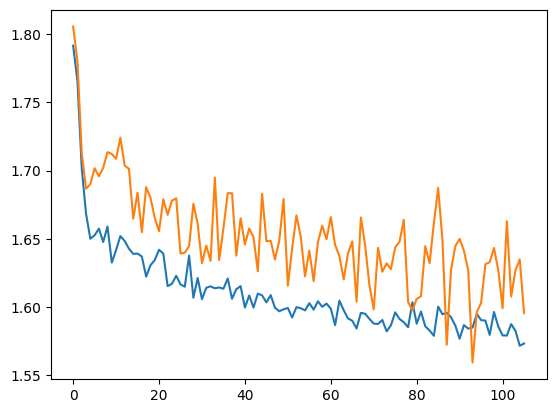

In [67]:
plt.plot(ttn.history['loss_train'])
plt.plot(ttn.history['loss_validation'])

## 6. Early Detection Model
### 6.1. Model Definition
- Define the new early detection model, incorporating the pretrained GNN.

### 6.2. Loss Function
- Describe the loss function used for early detection.


In [68]:
class EarlyLoss(torch.nn.Module):

    def __init__(self, device):

        super(EarlyLoss, self).__init__()

        self.CE = torch.nn.CrossEntropyLoss(
            reduction='none'
        )

        self.device = device

    def forward(
        self,
        predictions: torch.tensor,
        labels: torch.tensor,
        steps: torch.tensor,
        batches: torch.tensor
    ):
        
        L_CE = (self.CE(predictions, labels) * steps).sum()

        y = torch.softmax(predictions, dim=1).argmax(dim=1)
        pos_mask = y == 1


        L_TIME = 0
        time_scores = []
        
        for i in range(batches.max()):

            batch_mask = batches == i

            # Filter steps and preds using the mask
            filtered_steps = steps[batch_mask & pos_mask]
            # filtered_preds = predictions[batch_mask & pos_mask]

            # Check if there are any valid values after masking
            if filtered_steps.numel() > 0:
                # Find the index of the minimum step value
                min_step_idx = torch.argmin(filtered_steps)

                # Get the prediction corresponding to the minimum step
                # min_step_pred = filtered_preds[min_step_idx]
                if labels[min_step_idx] == 1:
                    time_scores.append(
                        (min_step_idx + 1) / (batch_mask.size(0) + 1)
                    )
            elif labels[i] == 1:

                stps = steps[batch_mask]
                if stps.numel() > 0:
                    time_scores.append(1)

        return L_CE, 0, torch.tensor(time_scores, dtype=torch.float32).mean() if time_scores else torch.tensor(0, dtype=torch.float32)

In [69]:
class EarlyNet(torch.nn.Module):

    def __init__(self, gnn, mlp, device):

        super(EarlyNet, self).__init__()

        self.GNN = gnn
        self.MLP = mlp
        
        self.TE = TemporalEncoding(dimension=770, device=device)

        self.device = device
    
    def compile(self, optimizer, loss, lr: float=0.0005):

        self.optimizer = optimizer(
            self.parameters(),
            lr=lr
        )
        self.loss = loss

        self.history = {
            'loss_train': [],
            'ce_train': [],
            'time_train': [],
            'acc_train': [],
            'time_score_train': [],
            'loss_val': [],
            'ce_val': [],
            'time_val': [],
            'acc_val': [],
            'time_score_val': []
        }

    def forward(self, data):

        datas = [data[i] for i in range(len(data))]
        for d in datas:
            add_cls_node(d)
        batch = pyg.data.Batch.from_data_list(datas).to(self.device)

        x_dict = batch.x_dict
        edge_index_dict = batch.edge_index_dict

        # Apply temporal encoding to the node features
        for node_type in batch.node_types:

            if node_type == 'cls':
                continue
    
            _, counts = torch.unique(batch[node_type].batch, return_counts=True)
            timesteps = torch.cat([torch.arange(count) for count in counts]).to(self.device)

            temporal_features = self.TE(timesteps)
            x_dict[node_type][:, :770] += temporal_features



        e = self.GNN(x_dict, edge_index_dict)

        ##### skip connection from context to extracted representation #####
        news_features = [
            d['tweet'].x[0, :] for d in datas
        ]
            
        z = self.MLP(
            torch.cat(
                [
                    e['cls'],
                    torch.stack(news_features)
                ],
                dim=-1
            ) 
        )
        ####################################################################

        return z, batch['cls'].batch

    def train_step(self, batch, batch_size):

        self.train()
        self.optimizer.zero_grad()

        datas = []
        for i, data in enumerate(batch):
            for t in range(data.timesteps):

                temp = data.clone()
                for edge_type in temp.edge_types:
                    if 'cls' in edge_type:
                        continue
                    mask = temp[edge_type].time <= t
                    temp[edge_type].edge_index = temp[edge_type].edge_index[:, mask]
                temp.step = t + 1
                temp.index = i
                datas.append(temp)
        
        loader = pyg.loader.DataLoader(
            datas, 
            batch_size=batch_size, 
            shuffle=True
        )

        preds = []
        labels = []
        steps = []
        batches = []
        for batch_data in loader:

            batch_data = batch_data.to(self.device)

            y, cls_batch = self(batch_data)

            preds.append(y)
            labels.append(batch_data.y.detach())
            steps.append(batch_data.step.detach())
            # batches.append(cls_batch.detach())
            batches.append(batch_data.index.detach())

        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
        steps = torch.cat(steps, dim=0)
        batches = torch.cat(batches, dim=0)

        l_ce, l_time, time_score = self.loss(preds, labels, steps, batches)

        loss = l_time + l_ce / steps.sum()
        # TODO: do the same for users
        loss.backward()
        self.optimizer.step()



        # Select predictions for the last step of each conversation
        # unique_batches = torch.unique(batches)
        # last_preds, last_labels = [], []

        # for ub in unique_batches:
        #     thread_mask = (batches == ub)
        #     last_step_idx = torch.argmax(steps[thread_mask])  # Find the last step
        #     last_preds.append(preds[thread_mask][last_step_idx])
        #     last_labels.append(labels[thread_mask][last_step_idx])

        # last_preds = torch.stack(last_preds, dim=0)
        # last_labels = torch.stack(last_labels, dim=0)

        batch = pyg.data.Batch.from_data_list(batch).to(self.device)
        p = self(batch)[0]


        # Compute accuracy
        correct = (torch.softmax(p, dim=1).argmax(dim=1) == batch.y).sum().item()
        accuracy = correct / len(batch.y)

        return loss.item(), l_ce / steps.sum(), l_time, time_score, accuracy
            

    def test_step(self, batch, batch_size):

        self.eval()

        datas = []
        for i, data in enumerate(batch):
            for t in range(data.timesteps):

                temp = data.clone()
                for edge_type in temp.edge_types:
                    if 'cls' in edge_type:
                        continue
                    mask = temp[edge_type].time <= t
                    temp[edge_type].edge_index = temp[edge_type].edge_index[:, mask]
                temp.step = t + 1
                temp.index = i
                datas.append(temp)
        
        loader = pyg.loader.DataLoader(
            datas, 
            batch_size=batch_size, 
            shuffle=True
        )

        preds = []
        labels = []
        steps = []
        batches = []
        with torch.no_grad():
            for batch_data in loader:

                batch_data = batch_data.to(self.device)

                y, cls_batch = self(batch_data)
                # l_ce += torch.sum(self.loss(y, batch_data) * batch_data.step).detach()

                preds.append(y.detach())
                labels.append(batch_data.y.detach())
                steps.append(batch_data.step.detach())
                # batches.append(cls_batch.detach())
                batches.append(batch_data.index.detach())

        preds = torch.cat(preds, dim=0)
        labels = torch.cat(labels, dim=0)
        steps = torch.cat(steps, dim=0)
        batches = torch.cat(batches, dim=0)

        l_ce, l_time, time_score = self.loss(preds, labels, steps, batches)

        loss = l_time + l_ce / steps.sum()

        # Select predictions for the last step of each conversation
        # unique_batches = torch.unique(batches)
        # last_preds, last_labels = [], []

        # for ub in unique_batches:
        #     thread_mask = (batches == ub)
        #     last_step_idx = torch.argmax(steps[thread_mask])  # Find the last step
        #     last_preds.append(preds[thread_mask][last_step_idx])
        #     last_labels.append(labels[thread_mask][last_step_idx])

        # last_preds = torch.stack(last_preds, dim=0)
        # last_labels = torch.stack(last_labels, dim=0)

        # # Compute accuracy
        # correct = (torch.softmax(last_preds, dim=1).argmax(dim=1) == last_labels).sum().item()
        # accuracy = correct / len(last_labels)

        batch = pyg.data.Batch.from_data_list(batch).to(self.device)
        p = self(batch)[0]


        # Compute accuracy
        correct = (torch.softmax(p, dim=1).argmax(dim=1) == batch.y).sum().item()
        accuracy = correct / len(batch.y)

        
        return loss.item(), l_ce / steps.sum(), l_time, time_score, accuracy

    def fit(self, data_train, data_validation=None, epochs: int=1000, batch_size: int=32, verbose: bool=False):

        train_loader = torch.utils.data.DataLoader(
            data_train, 
            batch_size=batch_size, 
            shuffle=True, 
            collate_fn=lambda graphs: graphs
        )

        if data_validation:

            val_loader = torch.utils.data.DataLoader(
                data_validation, 
                batch_size=batch_size, 
                shuffle=True, 
                collate_fn=lambda graphs: graphs
            )

        for epoch in range(epochs):

            train_loss, train_ce, train_time, time_scores, acc= 0, 0, 0, 0, 0
            total, correct = 0, 0
            progbar = tqdm(train_loader, desc='')

            for batch_idx, batch in enumerate(progbar):

                loss, l_ce, l_time, time_score, accuracy = self.train_step(batch=batch, batch_size=256)
                train_loss += loss
                train_ce += l_ce
                train_time += l_time
                time_scores += time_score
                acc += accuracy

                log = 'FINETUNING - Epoch {:03d}/{} - Training   Set => Overal Loss: {:.4f} - CE Loss: {:.4f} - Time Loss: {:.4f} - Time Score: {:.4f} - ACC: {:.4f} '.format(
                    epoch + 1,
                    epochs,
                    train_loss / (batch_idx + 1),
                    train_ce / (batch_idx + 1),
                    train_time / (batch_idx + 1),
                    time_scores / (batch_idx + 1),
                    acc / (batch_idx + 1)
                )

                progbar.set_description(log)
            
            self.history['loss_train'].append(train_loss / (batch_idx + 1))
            self.history['ce_train'].append(train_ce / (batch_idx + 1))
            self.history['time_train'].append(train_time / (batch_idx + 1))
            self.history['time_score_train'].append(time_scores / (batch_idx + 1))
            self.history['acc_train'].append(acc / (batch_idx + 1))
            
            if data_validation:

                val_loss, val_ce, val_time, time_scores, acc = 0, 0, 0, 0, 0

                for batch_idx, batch in enumerate(val_loader):

                    loss, l_ce, l_time, time_score, accuracy = self.test_step(batch=batch, batch_size=32)
                    val_loss += loss
                    val_ce += l_ce
                    val_time += l_time
                    time_scores += time_score
                    acc += accuracy
                
                log_val = '                           Validation Set => Overal Loss: {:.4f} - CE Loss: {:.4f} - Time Loss: {:.4f} - Time Score: {:.4f} - ACC: {:.4f} '.format(
                    val_loss / (batch_idx + 1),
                    val_ce / (batch_idx + 1),
                    val_time / (batch_idx + 1),
                    time_scores / (batch_idx + 1),
                    acc / (batch_idx + 1)
                )

                print(log_val)
                print(120 * '=')

                # update history
                self.history['loss_val'].append(val_loss / (batch_idx + 1))
                self.history['ce_val'].append(val_ce / (batch_idx + 1))
                self.history['time_val'].append(val_time / (batch_idx + 1))
                self.history['time_score_val'].append(time_scores / (batch_idx + 1))
                self.history['acc_val'].append(acc / (batch_idx + 1))
                
                acc = acc / (batch_idx + 1)
                self.history['acc_val'].append(acc)
                if acc >= max(self.history['acc_val']):
                    torch.save(self, f'ENET_{epoch}_{int(acc * 100)}.pt')


### 6.3. Fine-Tunning
- Code for training the early detection model and tracking metrics.

In [70]:
for param in ttn.DECODER.parameters():

    param.requires_grad = False

for param in ttn.GNN.parameters():

    param.requires_grad = False

for param in ttn.DECODER.parameters():

    print(param.requires_grad)

for param in ttn.GNN.parameters():

    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [27]:
torch.nn.ELU()

ELU(alpha=1.0)

In [27]:
device = torch.device('cuda')
mlp = MLP(
    [
        torch.nn.Linear(20 + 770, 512),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(512, 512),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(512, 512),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(512, 512),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(512, 256),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(256, 128),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(128, 32),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.2),
        torch.nn.Linear(32, 2)
    ],
    device=device,
    activation=torch.nn.Softmax()
)

enet = EarlyNet(gnn=ttn.GNN, mlp=mlp, device=device)
enet.compile(
    optimizer=torch.optim.Adam, 
    loss=EarlyLoss(device=device),
    lr=0.001
)

In [28]:
enet.fit(
    data_train=data_train, 
    data_validation=data_val, 
    epochs=5, 
    batch_size=32
)

FINETUNING - Epoch 001/5 - Training   Set => Overal Loss: 0.4261 - CE Loss: 0.4261 - Time Loss: 0.0000 - Time Score: 0.4842 - ACC: 0.7682 : 100%|██████████| 141/141 [01:57<00:00,  1.20it/s]


                           Validation Set => Overal Loss: 0.5580 - CE Loss: 0.5580 - Time Loss: 0.0000 - Time Score: 0.4956 - ACC: 0.7832 


FINETUNING - Epoch 002/5 - Training   Set => Overal Loss: 0.4320 - CE Loss: 0.4320 - Time Loss: 0.0000 - Time Score: 0.5506 - ACC: 0.7762 : 100%|██████████| 141/141 [01:57<00:00,  1.20it/s]


                           Validation Set => Overal Loss: 0.5060 - CE Loss: 0.5060 - Time Loss: 0.0000 - Time Score: 0.5248 - ACC: 0.7768 


FINETUNING - Epoch 003/5 - Training   Set => Overal Loss: 0.4041 - CE Loss: 0.4041 - Time Loss: 0.0000 - Time Score: 0.5556 - ACC: 0.7798 : 100%|██████████| 141/141 [01:56<00:00,  1.22it/s]


                           Validation Set => Overal Loss: 0.5353 - CE Loss: 0.5353 - Time Loss: 0.0000 - Time Score: 0.5305 - ACC: 0.7917 


FINETUNING - Epoch 004/5 - Training   Set => Overal Loss: 0.3940 - CE Loss: 0.3940 - Time Loss: 0.0000 - Time Score: 0.5147 - ACC: 0.7773 : 100%|██████████| 141/141 [01:58<00:00,  1.19it/s]


                           Validation Set => Overal Loss: 0.6078 - CE Loss: 0.6078 - Time Loss: 0.0000 - Time Score: 0.3706 - ACC: 0.7550 


FINETUNING - Epoch 005/5 - Training   Set => Overal Loss: 0.3773 - CE Loss: 0.3773 - Time Loss: 0.0000 - Time Score: 0.5148 - ACC: 0.7930 : 100%|██████████| 141/141 [01:56<00:00,  1.21it/s]


                           Validation Set => Overal Loss: 0.4980 - CE Loss: 0.4980 - Time Loss: 0.0000 - Time Score: 0.4899 - ACC: 0.7917 


In [41]:
enet.fit(
    data_train=data_train, 
    data_validation=data_val, 
    epochs=5, 
    batch_size=32
)

FINETUNING - Epoch 001/5 - Training   Set => Overal Loss: 0.3774 - CE Loss: 0.3774 - Time Loss: 0.0000 - Time Score: 0.5301 - ACC: 0.7905 : 100%|██████████| 141/141 [02:18<00:00,  1.02it/s]


                           Validation Set => Overal Loss: 0.6546 - CE Loss: 0.6546 - Time Loss: 0.0000 - Time Score: 0.6094 - ACC: 0.7862 


FINETUNING - Epoch 002/5 - Training   Set => Overal Loss: 0.3603 - CE Loss: 0.3603 - Time Loss: 0.0000 - Time Score: 0.5339 - ACC: 0.7898 : 100%|██████████| 141/141 [02:23<00:00,  1.02s/it]


                           Validation Set => Overal Loss: 0.5316 - CE Loss: 0.5316 - Time Loss: 0.0000 - Time Score: 0.4283 - ACC: 0.7579 


FINETUNING - Epoch 003/5 - Training   Set => Overal Loss: 0.3714 - CE Loss: 0.3714 - Time Loss: 0.0000 - Time Score: 0.5216 - ACC: 0.7955 : 100%|██████████| 141/141 [02:21<00:00,  1.00s/it]


                           Validation Set => Overal Loss: 0.5277 - CE Loss: 0.5277 - Time Loss: 0.0000 - Time Score: 0.5174 - ACC: 0.7961 


FINETUNING - Epoch 004/5 - Training   Set => Overal Loss: 0.3827 - CE Loss: 0.3827 - Time Loss: 0.0000 - Time Score: 0.5499 - ACC: 0.7911 : 100%|██████████| 141/141 [02:21<00:00,  1.01s/it]


                           Validation Set => Overal Loss: 0.5230 - CE Loss: 0.5230 - Time Loss: 0.0000 - Time Score: 0.6077 - ACC: 0.7946 


FINETUNING - Epoch 005/5 - Training   Set => Overal Loss: 0.3557 - CE Loss: 0.3557 - Time Loss: 0.0000 - Time Score: 0.5287 - ACC: 0.7853 : 100%|██████████| 141/141 [02:23<00:00,  1.02s/it]


                           Validation Set => Overal Loss: 0.5810 - CE Loss: 0.5810 - Time Loss: 0.0000 - Time Score: 0.5178 - ACC: 0.7902 


In [46]:
enet.fit(
    data_train=data_train, 
    data_validation=data_val, 
    epochs=5, 
    batch_size=32
)

FINETUNING - Epoch 001/5 - Training   Set => Overal Loss: 0.3341 - CE Loss: 0.3341 - Time Loss: 0.0000 - Time Score: 0.5163 - ACC: 0.7993 : 100%|██████████| 141/141 [02:23<00:00,  1.02s/it]


                           Validation Set => Overal Loss: 0.5749 - CE Loss: 0.5749 - Time Loss: 0.0000 - Time Score: 0.5091 - ACC: 0.7862 


FINETUNING - Epoch 002/5 - Training   Set => Overal Loss: 0.3253 - CE Loss: 0.3253 - Time Loss: 0.0000 - Time Score: 0.5570 - ACC: 0.7947 : 100%|██████████| 141/141 [01:50<00:00,  1.28it/s]


                           Validation Set => Overal Loss: 0.5298 - CE Loss: 0.5298 - Time Loss: 0.0000 - Time Score: 0.4895 - ACC: 0.8021 


FINETUNING - Epoch 003/5 - Training   Set => Overal Loss: 0.3328 - CE Loss: 0.3328 - Time Loss: 0.0000 - Time Score: 0.5199 - ACC: 0.7987 : 100%|██████████| 141/141 [02:00<00:00,  1.17it/s]


                           Validation Set => Overal Loss: 0.6321 - CE Loss: 0.6321 - Time Loss: 0.0000 - Time Score: 0.5039 - ACC: 0.7773 


FINETUNING - Epoch 004/5 - Training   Set => Overal Loss: 0.3087 - CE Loss: 0.3087 - Time Loss: 0.0000 - Time Score: 0.5366 - ACC: 0.8061 : 100%|██████████| 141/141 [02:21<00:00,  1.00s/it]


                           Validation Set => Overal Loss: 0.6963 - CE Loss: 0.6963 - Time Loss: 0.0000 - Time Score: 0.6061 - ACC: 0.7842 


FINETUNING - Epoch 005/5 - Training   Set => Overal Loss: 0.3421 - CE Loss: 0.3421 - Time Loss: 0.0000 - Time Score: 0.5390 - ACC: 0.7963 : 100%|██████████| 141/141 [02:22<00:00,  1.01s/it]


                           Validation Set => Overal Loss: 0.7062 - CE Loss: 0.7062 - Time Loss: 0.0000 - Time Score: 0.4360 - ACC: 0.8006 


In [52]:
enet.fit(
    data_train=data_train, 
    data_validation=data_val, 
    epochs=5, 
    batch_size=32
)

FINETUNING - Epoch 001/5 - Training   Set => Overal Loss: 0.3459 - CE Loss: 0.3459 - Time Loss: 0.0000 - Time Score: 0.5277 - ACC: 0.7951 : 100%|██████████| 141/141 [02:02<00:00,  1.15it/s]


                           Validation Set => Overal Loss: 0.7050 - CE Loss: 0.7050 - Time Loss: 0.0000 - Time Score: 0.4653 - ACC: 0.7798 


FINETUNING - Epoch 002/5 - Training   Set => Overal Loss: 0.3538 - CE Loss: 0.3538 - Time Loss: 0.0000 - Time Score: 0.5294 - ACC: 0.7754 : 100%|██████████| 141/141 [02:03<00:00,  1.14it/s]


                           Validation Set => Overal Loss: 0.6271 - CE Loss: 0.6271 - Time Loss: 0.0000 - Time Score: 0.5525 - ACC: 0.7723 


FINETUNING - Epoch 003/5 - Training   Set => Overal Loss: 0.3204 - CE Loss: 0.3204 - Time Loss: 0.0000 - Time Score: 0.5721 - ACC: 0.7950 : 100%|██████████| 141/141 [01:57<00:00,  1.20it/s]


                           Validation Set => Overal Loss: 0.6139 - CE Loss: 0.6139 - Time Loss: 0.0000 - Time Score: 0.5004 - ACC: 0.7932 


FINETUNING - Epoch 004/5 - Training   Set => Overal Loss: 0.3128 - CE Loss: 0.3128 - Time Loss: 0.0000 - Time Score: 0.5505 - ACC: 0.7953 : 100%|██████████| 141/141 [02:02<00:00,  1.15it/s]


                           Validation Set => Overal Loss: 0.6615 - CE Loss: 0.6615 - Time Loss: 0.0000 - Time Score: 0.5202 - ACC: 0.7733 


FINETUNING - Epoch 005/5 - Training   Set => Overal Loss: 0.3193 - CE Loss: 0.3193 - Time Loss: 0.0000 - Time Score: 0.5639 - ACC: 0.7915 : 100%|██████████| 141/141 [02:02<00:00,  1.15it/s]


                           Validation Set => Overal Loss: 0.5949 - CE Loss: 0.5949 - Time Loss: 0.0000 - Time Score: 0.5727 - ACC: 0.8051 


In [57]:
enet.fit(
    data_train=data_train, 
    data_validation=data_val, 
    epochs=5, 
    batch_size=32
)

FINETUNING - Epoch 001/5 - Training   Set => Overal Loss: 0.3063 - CE Loss: 0.3063 - Time Loss: 0.0000 - Time Score: 0.4868 - ACC: 0.8027 : 100%|██████████| 141/141 [02:04<00:00,  1.14it/s]


                           Validation Set => Overal Loss: 0.7474 - CE Loss: 0.7474 - Time Loss: 0.0000 - Time Score: 0.5585 - ACC: 0.7753 


FINETUNING - Epoch 002/5 - Training   Set => Overal Loss: 0.2881 - CE Loss: 0.2881 - Time Loss: 0.0000 - Time Score: 0.5403 - ACC: 0.8066 : 100%|██████████| 141/141 [01:57<00:00,  1.20it/s]


                           Validation Set => Overal Loss: 0.6558 - CE Loss: 0.6558 - Time Loss: 0.0000 - Time Score: 0.4199 - ACC: 0.7669 


FINETUNING - Epoch 003/5 - Training   Set => Overal Loss: 0.2918 - CE Loss: 0.2918 - Time Loss: 0.0000 - Time Score: 0.5556 - ACC: 0.7984 : 100%|██████████| 141/141 [01:59<00:00,  1.18it/s]


                           Validation Set => Overal Loss: 0.7589 - CE Loss: 0.7589 - Time Loss: 0.0000 - Time Score: 0.5561 - ACC: 0.7961 


FINETUNING - Epoch 004/5 - Training   Set => Overal Loss: 0.3156 - CE Loss: 0.3156 - Time Loss: 0.0000 - Time Score: 0.5338 - ACC: 0.7920 : 100%|██████████| 141/141 [01:58<00:00,  1.19it/s]


                           Validation Set => Overal Loss: 0.5979 - CE Loss: 0.5979 - Time Loss: 0.0000 - Time Score: 0.5364 - ACC: 0.8006 


FINETUNING - Epoch 005/5 - Training   Set => Overal Loss: 0.3126 - CE Loss: 0.3126 - Time Loss: 0.0000 - Time Score: 0.5249 - ACC: 0.7973 : 100%|██████████| 141/141 [02:09<00:00,  1.09it/s]


                           Validation Set => Overal Loss: 0.5984 - CE Loss: 0.5984 - Time Loss: 0.0000 - Time Score: 0.5240 - ACC: 0.7951 


In [26]:
enet.fit(
    data_train=data_train, 
    data_validation=data_val, 
    epochs=5, 
    batch_size=32
)

FINETUNING - Epoch 001/5 - Training   Set => Overal Loss: 0.4946 - CE Loss: 0.4946 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7547 : 100%|██████████| 141/141 [01:48<00:00,  1.30it/s]


                           Validation Set => Overal Loss: 0.5843 - CE Loss: 0.5843 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.6989 


FINETUNING - Epoch 002/5 - Training   Set => Overal Loss: 0.4417 - CE Loss: 0.4417 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7665 : 100%|██████████| 141/141 [01:54<00:00,  1.23it/s]


                           Validation Set => Overal Loss: 0.5523 - CE Loss: 0.5523 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7272 


FINETUNING - Epoch 003/5 - Training   Set => Overal Loss: 0.4156 - CE Loss: 0.4156 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7753 : 100%|██████████| 141/141 [01:53<00:00,  1.24it/s]


                           Validation Set => Overal Loss: 0.7015 - CE Loss: 0.7015 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7738 


FINETUNING - Epoch 004/5 - Training   Set => Overal Loss: 0.4431 - CE Loss: 0.4431 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7781 : 100%|██████████| 141/141 [01:55<00:00,  1.22it/s]


                           Validation Set => Overal Loss: 0.7599 - CE Loss: 0.7599 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7579 


FINETUNING - Epoch 005/5 - Training   Set => Overal Loss: 0.3885 - CE Loss: 0.3885 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7750 : 100%|██████████| 141/141 [01:56<00:00,  1.21it/s]


                           Validation Set => Overal Loss: 0.8783 - CE Loss: 0.8783 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7708 


In [36]:
enet.fit(
    data_train=data_train, 
    data_validation=data_val, 
    epochs=5, 
    batch_size=32
)

FINETUNING - Epoch 001/5 - Training   Set => Overal Loss: 0.4890 - CE Loss: 0.4890 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7648 : 100%|██████████| 141/141 [01:56<00:00,  1.21it/s]


                           Validation Set => Overal Loss: 0.5868 - CE Loss: 0.5868 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7669 


FINETUNING - Epoch 002/5 - Training   Set => Overal Loss: 0.4087 - CE Loss: 0.4087 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7761 : 100%|██████████| 141/141 [01:57<00:00,  1.20it/s]


                           Validation Set => Overal Loss: 0.5703 - CE Loss: 0.5703 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7450 


FINETUNING - Epoch 003/5 - Training   Set => Overal Loss: 0.3904 - CE Loss: 0.3904 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7754 : 100%|██████████| 141/141 [01:56<00:00,  1.21it/s]


                           Validation Set => Overal Loss: 0.6834 - CE Loss: 0.6834 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7525 


FINETUNING - Epoch 004/5 - Training   Set => Overal Loss: 0.3537 - CE Loss: 0.3537 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7772 : 100%|██████████| 141/141 [01:58<00:00,  1.19it/s]


                           Validation Set => Overal Loss: 0.5117 - CE Loss: 0.5117 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7654 


FINETUNING - Epoch 005/5 - Training   Set => Overal Loss: 0.3705 - CE Loss: 0.3705 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7828 : 100%|██████████| 141/141 [01:57<00:00,  1.20it/s]


                           Validation Set => Overal Loss: 0.7984 - CE Loss: 0.7984 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7594 


In [41]:
enet.fit(
    data_train=data_train, 
    data_validation=data_val, 
    epochs=5, 
    batch_size=32
)

FINETUNING - Epoch 001/5 - Training   Set => Overal Loss: 0.3353 - CE Loss: 0.3353 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7847 : 100%|██████████| 141/141 [01:57<00:00,  1.20it/s]


                           Validation Set => Overal Loss: 0.6708 - CE Loss: 0.6708 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7629 


FINETUNING - Epoch 002/5 - Training   Set => Overal Loss: 0.3571 - CE Loss: 0.3571 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7740 : 100%|██████████| 141/141 [01:55<00:00,  1.22it/s]


                           Validation Set => Overal Loss: 0.5938 - CE Loss: 0.5938 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7788 


FINETUNING - Epoch 003/5 - Training   Set => Overal Loss: 0.3061 - CE Loss: 0.3061 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7864 : 100%|██████████| 141/141 [01:56<00:00,  1.21it/s]


                           Validation Set => Overal Loss: 0.5641 - CE Loss: 0.5641 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7490 


FINETUNING - Epoch 004/5 - Training   Set => Overal Loss: 0.3390 - CE Loss: 0.3390 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7763 : 100%|██████████| 141/141 [01:57<00:00,  1.20it/s]


                           Validation Set => Overal Loss: 0.6044 - CE Loss: 0.6044 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7450 


FINETUNING - Epoch 005/5 - Training   Set => Overal Loss: 0.3091 - CE Loss: 0.3091 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7888 : 100%|██████████| 141/141 [01:55<00:00,  1.22it/s]


                           Validation Set => Overal Loss: 0.7048 - CE Loss: 0.7048 - Time Loss: 0.0000 - Time Score: 0 - ACC: 0.7138 


In [58]:
test_loader = pyg.data.DataLoader(
    data_test, 
    batch_size=32, 
    shuffle=True, 
)

/home/ag/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [34]:
train_loader = pyg.data.DataLoader(
    data_train, 
    batch_size=32, 
    shuffle=True, 
)

/home/ag/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [59]:
ps = []
ys = []
for batch_idx, batch in enumerate(test_loader):

    p = enet(batch.to(device))[0]
    ps.append(p)
    ys.append(batch.y)

In [35]:
ps = []
ys = []
for batch_idx, batch in enumerate(train_loader):

    p = enet(batch.to(device))[0]
    ps.append(p)
    ys.append(batch.y)

In [49]:
from sklearn.metrics import classification_report, roc_auc_score

In [60]:
print(
    classification_report(
        torch.cat(ys).cpu(), 
        torch.cat(ps).softmax(dim=1).argmax(dim=1).cpu()
    )
)

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       805
           1       0.70      0.75      0.73       480

    accuracy                           0.79      1285
   macro avg       0.77      0.78      0.78      1285
weighted avg       0.79      0.79      0.79      1285



In [50]:
print(
    classification_report(
        torch.cat(ys).cpu(), 
        torch.cat(ps).softmax(dim=1).argmax(dim=1).cpu()
    )
)

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       805
           1       0.72      0.80      0.76       480

    accuracy                           0.81      1285
   macro avg       0.79      0.81      0.80      1285
weighted avg       0.81      0.81      0.81      1285



In [36]:
print(
    classification_report(
        torch.cat(ys).cpu(), 
        torch.cat(ps).softmax(dim=1).argmax(dim=1).cpu()
    )
)

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      2815
           1       0.66      0.87      0.75      1682

    accuracy                           0.78      4497
   macro avg       0.78      0.80      0.78      4497
weighted avg       0.81      0.78      0.79      4497



In [51]:
roc_auc_score(torch.cat(ys).cpu(), torch.cat(ps).softmax(dim=1).cpu().detach().numpy()[:, 1])

0.8650181159420289

In [37]:
roc_auc_score(torch.cat(ys).cpu(), torch.cat(ps).softmax(dim=1).cpu().detach().numpy()[:, 1])

0.8617971500560738

In [39]:
from sklearn.metrics import accuracy_score, f1_score

In [62]:
accuracy_score(torch.cat(ys).cpu(), 
        torch.cat(ps).softmax(dim=1).argmax(dim=1).cpu())

0.7712062256809339

In [40]:
f1_score(torch.cat(ys).cpu(), 
        torch.cat(ps).softmax(dim=1).argmax(dim=1).cpu())

0.7511497189575882

In [125]:
datas = []
for i, data in tqdm(enumerate(pos_test)):
    for t in range(data.timesteps):

        temp = data.clone()
        for edge_type in temp.edge_types:
            if 'cls' in edge_type:
                continue
            mask = temp[edge_type].time <= t
            temp[edge_type].edge_index = temp[edge_type].edge_index[:, mask]
        temp.step = t + 1
        temp.index = i
        datas.append(temp)

loader = pyg.loader.DataLoader(
    datas, 
    batch_size=32, 
    shuffle=False
)

preds = []
labels = []
steps = []
batches = []
for batch_data in tqdm(loader):

    batch_data = batch_data.to(enet.device)

    y, cls_batch = enet(batch_data)

    preds.append(y)
    labels.append(batch_data.y.detach())
    steps.append(batch_data.step.detach())
    # batches.append(cls_batch.detach())
    batches.append(batch_data.index.detach())

480it [00:03, 153.02it/s]
100%|██████████| 215/215 [00:12<00:00, 17.81it/s]


In [134]:
preds = torch.cat(preds, dim=0)
labels = torch.cat(labels, dim=0)
steps = torch.cat(steps, dim=0)
batches = torch.cat(batches, dim=0)

In [153]:
torch.where(T.argmax(dim=1) == 1)

(tensor([1], device='cuda:0'),)

In [162]:
torch.norm(p=2)

TypeError: norm() missing 1 required positional argument: 'input'

In [176]:
s = 0
for idx in range(409, len(pos_test)):
    mask = batches == idx
    

    T = preds[mask].softmax(dim=1)
    try:
        min_idx = torch.where(T.argmax(dim=1) == 1)[0][0]
        T_after = T[min_idx:]
        print(min_idx, idx, (min_idx + 1) / T.size(0))
        print(torch.norm(T_after - T[min_idx], p=2))
        s += (min_idx + 1) / T.size(0)
    except:
        pass
    # break

tensor(1, device='cuda:0') 409 tensor(0.0465, device='cuda:0')
tensor(1.0560, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0, device='cuda:0') 410 tensor(0.0526, device='cuda:0')
tensor(0.0437, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0, device='cuda:0') 413 tensor(0.1667, device='cuda:0')
tensor(0.0569, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0, device='cuda:0') 414 tensor(0.2000, device='cuda:0')
tensor(0.0212, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0, device='cuda:0') 415 tensor(0.1667, device='cuda:0')
tensor(0.0455, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0, device='cuda:0') 416 tensor(0.0250, device='cuda:0')
tensor(0.0717, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0, device='cuda:0') 417 tensor(0.0385, device='cuda:0')
tensor(0.1005, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
tensor(0, device='cuda:0') 418 tensor(0.0476, device='cuda:0')
tensor(0.0295

In [178]:
len(pos_test)

480

In [177]:
s

tensor(14.9289, device='cuda:0')

In [121]:
idx = 0
for pred, batch in zip(preds, batches):
    mask = batch
    T = pred.softmax(dim=1).argmax(dim=1)
    if T[0] == 0:
        print(pred.softmax(dim=1))
        print(pred.softmax(dim=1).argmax(dim=1))
        count = 0
        for t in T:
            if t == 1:
                break
            count += 1
        print(count)
        idx += 1
    # break

tensor([[0.6105, 0.3895]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
1
tensor([[0.5741, 0.4259]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
1
tensor([[0.7769, 0.2231]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
1
tensor([[0.6909, 0.3091]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
1
tensor([[0.5312, 0.4688]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
1
tensor([[0.5279, 0.4721]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
1
tensor([[0.7401, 0.2599]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
1
tensor([[0.5745, 0.4255]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
1
tensor([[0.5972, 0.4028]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0], device='cuda:0')
1
tensor([[0.5268, 0.4732]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
t

In [112]:
idx

75

In [95]:
pos_test = [d for d in data_test if d.y == 1]

In [98]:
len(data_test)

1285

In [97]:
len(pos_test)

480

In [90]:
data_test[0].y[0]

tensor(1)

In [94]:
preds[0]

tensor([[ 0.2719,  0.1240],
        [ 0.2667,  0.1273],
        [ 0.2390,  0.1446],
        [ 0.2236,  0.1541],
        [ 0.2454,  0.1406],
        [ 0.9543, -0.2893],
        [ 0.2193,  0.1567]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [92]:
preds[0].softmax(dim=1).argmax(dim=1)

tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [93]:
labels

[tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0')]

## 7. Evaluation
### 7.1. Metrics
- Define the metrics used for evaluating both the self-supervised and early detection phases.


### 7.2. Results
- Display and analyze results with visualizations (e.g., loss curves, accuracy trends).
- Include a table summarizing key metrics such as accuracy, F1-score, precision, and recall, alongside the visualizations.

---

## 8. Conclusion
Summarize findings, observations, and potential improvements.


In [22]:
import gc

In [30]:
val_emb = []
for i, data in tqdm(enumerate(data_val)):
    datas = []
    for t in range(data.timesteps):

        temp = data.clone()
        for edge_type in temp.edge_types:
            if 'cls' in edge_type:
                continue
            mask = temp[edge_type].time <= t
            temp[edge_type].edge_index = temp[edge_type].edge_index[:, mask]
        temp.step = t + 1
        temp.index = i
        datas.append(temp)
    
    for d in datas:
        add_cls_node(d)
    batch = pyg.data.Batch.from_data_list(datas).to(ttn.device)
    del datas
    x_dict = batch.x_dict
    edge_index_dict = batch.edge_index_dict

    # Apply temporal encoding to the node features
    for node_type in batch.node_types:

        if node_type == 'cls':
            continue

        _, counts = torch.unique(batch[node_type].batch, return_counts=True)
        timesteps = torch.cat([torch.arange(count) for count in counts]).to(ttn.device)

        temporal_features = ttn.TE(timesteps)
        x_dict[node_type][:, :770] += temporal_features


    with torch.no_grad():
        e = ttn.GNN(x_dict, edge_index_dict)
        val_emb.append(e['cls'].to(torch.device('cpu')))
    # torch.cuda.empty_cache()
    # gc.collect()

0it [00:00, ?it/s]

82it [00:02, 28.63it/s]


In [32]:
# torch.save(train_emb, 'TTNP_EMB_train.pt')
# torch.save(test_emb, 'TTNP_EMB_test.pt')
# torch.save(val_emb, 'TTNP_EMB_val.pt')

In [33]:
train_emb = torch.load('TTNP_EMB_train.pt')
val_emb = torch.load('TTNP_EMB_val.pt')
test_emb = torch.load('TTNP_EMB_test.pt')

In [34]:
from sklearn.decomposition import PCA

In [281]:
x_train = torch.stack([emb[-1:, ] for emb in train_emb]).squeeze(dim=1)
x_val = torch.stack([emb[-1:, ] for emb in val_emb]).squeeze(dim=1)
x_test = torch.stack([emb[-1:, ] for emb in test_emb]).squeeze(dim=1)

In [683]:
x_train = torch.stack([torch.cat([emb[-1:, ], d['tweet'].x[0, :].unsqueeze(dim=1).t()], dim=1) for emb, d in zip(train_emb, data_train)]).squeeze(dim=1)
x_val = torch.stack([torch.cat([emb[-1:, ], d['tweet'].x[0, :].unsqueeze(dim=1).t()], dim=1) for emb, d in zip(val_emb, data_val)]).squeeze(dim=1)
x_test = torch.stack([torch.cat([emb[-1:, ], d['tweet'].x[0, :].unsqueeze(dim=1).t()], dim=1) for emb, d in zip(test_emb, data_test)]).squeeze(dim=1)

In [685]:
x_train.size()

torch.Size([571, 790])

In [79]:
x_train.size()

torch.Size([571, 790])

In [449]:
x_test.size()

torch.Size([1285, 790])

In [182]:
data_train[0]['tweet'].x

tensor([[-0.3227,  1.5678,  1.5827,  ...,  0.3067,  0.1988,  0.0000],
        [-0.0258, -0.8501, -0.6153,  ..., -0.3715, -0.0508,  0.0000],
        [-0.6634, -1.4512, -0.5263,  ...,  0.8864, -0.0531,  0.0000],
        ...,
        [-0.3666, -0.0122,  0.2168,  ...,  0.9287, -0.0531,  0.0000],
        [-0.8530, -0.0559,  1.2824,  ...,  1.1186, -0.0508,  0.0000],
        [-1.7116, -1.3711, -0.8348,  ...,  1.6620, -0.0531,  0.0000]])

In [35]:
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

In [109]:
x_train

tensor([[ 4.1666e+00, -1.2121e+00,  8.3313e-01,  ...,  4.7604e-01,
         -6.8205e+00,  1.2840e+01],
        [ 6.8739e-01, -7.2798e-01, -7.1146e-01,  ..., -2.0660e-02,
         -1.6116e+00,  4.5310e+00],
        [ 1.0324e+00, -1.1558e+00, -2.0078e+00,  ..., -2.6994e-01,
         -4.7583e+00,  1.1466e+01],
        ...,
        [-2.1781e+00, -1.7228e+00, -1.1137e+00,  ..., -1.0397e+00,
         -2.5775e+00,  3.4123e+00],
        [-2.3901e+00, -1.3149e+00,  2.2408e-01,  ..., -1.0282e+00,
         -1.0670e-03, -1.7771e+00],
        [ 2.7643e-01,  1.3248e-01,  1.2659e+00,  ...,  1.1537e-01,
          3.9931e-01, -1.9875e+00]])

In [735]:
class MLP(torch.nn.Module):

    def __init__(
        self, 
        layers: list[torch.nn.Module],
        activation: torch.nn.Module=torch.nn.Sigmoid(),
        device: torch.device=torch.device('cpu')
    ):
        
        super(MLP, self).__init__()

        self.network = torch.nn.Sequential(
            *layers
        )

        self.activation = activation
        
        self.device = device
        self.to(device)
    
    def compile(
        self,
        optimizer,
        loss
    ):
        
        self.optimizer = optimizer(
            self.parameters(),
            lr=0.001
        )
        self.loss = loss

        self.history = {
            'loss_train': [],
            'loss_validation': [],
            'accuracy_train': [],
            'accuracy_validation': []
        }
    
    def forward(self, x):

        z = self.network(x)

        logits = torch.argmax(
            self.activation(z),
            dim=1
        )

        return self.network(x), logits
    
    def train_step(self, data):

        self.train()

        x, y = data

        self.optimizer.zero_grad()

        z, logits = self(x)

        loss = self.loss(z, y)

        loss.backward()
        self.optimizer.step()

        return loss.item(), logits
    
    def test_step(self, data):

        self.eval()

        x, y = data

        with torch.no_grad():

            z, logits = self(x)
            loss = self.loss(z, y)
        
        return loss.item(), logits
    
    def fit(
        self,
        data_train: tuple,
        data_validation: tuple=None,
        epochs: int=10,
        batch_size: int=32
    ):
        
        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(*data_train),
            batch_size=batch_size,
            shuffle=True
        )

        if data_validation:
            
            val_loader = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(*data_validation),
                batch_size=batch_size,
                shuffle=True
            )
        
        for epoch in range(epochs):

            train_loss, train_correct, train_total = 0, 0, 0

            progbar = tqdm(train_loader, desc='')

            for batch_idx, batch in enumerate(progbar):

                x_batch = batch[0].to(self.device)
                y_batch = batch[1].to(self.device)

                loss, preds = self.train_step((x_batch, y_batch))

                train_loss += loss

                train_correct += (preds == y_batch).sum().item()
                train_total += y_batch.size(0)

                log = 'Epoch {:03d}/{} - Training Loss : {:.4f} - Training Accuracy : {:.4f} '.format(
                    epoch + 1,
                    epochs,
                    train_loss / (batch_idx + 1),
                    train_correct / train_total
                )

                progbar.set_description(log)
            
            # update history
            self.history['loss_train'].append(train_loss / len(train_loader))
            self.history['accuracy_train'].append(train_correct / train_total)

            if data_validation:

                val_loss, val_correct, val_total = 0, 0, 0

                for batch_idx, batch in enumerate(val_loader):

                    x_batch = batch[0].to(self.device)
                    y_batch = batch[1].to(self.device)

                    loss, preds = self.test_step((x_batch, y_batch))

                    val_loss += loss

                    val_correct += (preds == y_batch).sum().item()
                    val_total += y_batch.size(0)

                log_val = '              Val      Loss : {:.4f} - Val      Accuracy : {:.4f} '.format(
                    val_loss / len(val_loader),
                    val_correct / val_total
                )

                print(log_val)
                print(120 * '=')

                # update history
                self.history['loss_validation'].append(val_loss / len(val_loader))
                self.history['accuracy_validation'].append(val_correct / val_total)
     
    def evaluate(self, data):

        data_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(*data),
            batch_size=32,
            shuffle=False
        )

        self.eval()

        loss, correct, total = 0, 0, 0

        with torch.no_grad():

            for batch in data_loader:

                x_batch = batch[0].to(self.device)
                y_batch = batch[1].to(self.device)

                loss_step, preds = self.test_step((x_batch, y_batch))
                loss += loss_step

                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        
        accuracy = correct / total

        return loss / len(data_loader), accuracy

    def predict(self, data):

        data_loader = torch.utils.data.DataLoader(
            data,
            batch_size=32,
            shuffle=False
        )

        self.eval()
        predictions = []

        with torch.no_grad():

            for batch in data_loader:

                batch = batch.to(self.device)

                z, _ = self(batch)
                predictions.append(
                    self.activation(z)
                )

        return torch.cat(predictions, dim=0)

In [849]:
mlp = MLP(
    [
        torch.nn.Linear(790, 512),
        torch.nn.BatchNorm1d(512),
        torch.nn.GELU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(512, 512),
        torch.nn.BatchNorm1d(512),
        torch.nn.GELU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(512, 256),
        torch.nn.BatchNorm1d(256),
        torch.nn.GELU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(256, 128),
        torch.nn.BatchNorm1d(128),
        torch.nn.GELU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(128, 64),
        torch.nn.BatchNorm1d(64),
        torch.nn.GELU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(64, 2)
    ],
    device=torch.device('cuda'),
    activation=torch.nn.LogSoftmax()
)

In [850]:
mlp.compile(
    optimizer=torch.optim.SGD, 
    loss=torch.nn.CrossEntropyLoss()
)

In [851]:
x_train.size()

torch.Size([571, 790])

In [852]:
mlp.fit(data_train=(x_train, y_train), data_validation=(x_val, y_val), epochs=130)

  0%|          | 0/18 [00:00<?, ?it/s]/home/ag/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Epoch 001/130 - Training Loss : 0.7568 - Training Accuracy : 0.4588 : 100%|██████████| 18/18 [00:00<00:00, 111.61it/s]


              Val      Loss : 0.7094 - Val      Accuracy : 0.4268 


Epoch 002/130 - Training Loss : 0.7376 - Training Accuracy : 0.4676 : 100%|██████████| 18/18 [00:00<00:00, 158.64it/s]


              Val      Loss : 0.7069 - Val      Accuracy : 0.4512 


Epoch 003/130 - Training Loss : 0.7276 - Training Accuracy : 0.4834 : 100%|██████████| 18/18 [00:00<00:00, 173.69it/s]


              Val      Loss : 0.6934 - Val      Accuracy : 0.4756 


Epoch 004/130 - Training Loss : 0.7499 - Training Accuracy : 0.5289 : 100%|██████████| 18/18 [00:00<00:00, 163.47it/s]


              Val      Loss : 0.6910 - Val      Accuracy : 0.4634 


Epoch 005/130 - Training Loss : 0.7215 - Training Accuracy : 0.5044 : 100%|██████████| 18/18 [00:00<00:00, 143.61it/s]


              Val      Loss : 0.6832 - Val      Accuracy : 0.5122 


Epoch 006/130 - Training Loss : 0.7257 - Training Accuracy : 0.5254 : 100%|██████████| 18/18 [00:00<00:00, 148.91it/s]


              Val      Loss : 0.6848 - Val      Accuracy : 0.5000 


Epoch 007/130 - Training Loss : 0.7165 - Training Accuracy : 0.5114 : 100%|██████████| 18/18 [00:00<00:00, 153.78it/s]


              Val      Loss : 0.6758 - Val      Accuracy : 0.5854 


Epoch 008/130 - Training Loss : 0.7334 - Training Accuracy : 0.4939 : 100%|██████████| 18/18 [00:00<00:00, 162.57it/s]


              Val      Loss : 0.6760 - Val      Accuracy : 0.5854 


Epoch 009/130 - Training Loss : 0.7167 - Training Accuracy : 0.5797 : 100%|██████████| 18/18 [00:00<00:00, 170.74it/s]


              Val      Loss : 0.6663 - Val      Accuracy : 0.6707 


Epoch 010/130 - Training Loss : 0.7023 - Training Accuracy : 0.5114 : 100%|██████████| 18/18 [00:00<00:00, 160.05it/s]


              Val      Loss : 0.6653 - Val      Accuracy : 0.6341 


Epoch 011/130 - Training Loss : 0.7089 - Training Accuracy : 0.5464 : 100%|██████████| 18/18 [00:00<00:00, 159.09it/s]


              Val      Loss : 0.6589 - Val      Accuracy : 0.6951 


Epoch 012/130 - Training Loss : 0.7023 - Training Accuracy : 0.5306 : 100%|██████████| 18/18 [00:00<00:00, 144.44it/s]


              Val      Loss : 0.6625 - Val      Accuracy : 0.6707 


Epoch 013/130 - Training Loss : 0.6996 - Training Accuracy : 0.5499 : 100%|██████████| 18/18 [00:00<00:00, 143.82it/s]


              Val      Loss : 0.6591 - Val      Accuracy : 0.7195 


Epoch 014/130 - Training Loss : 0.6972 - Training Accuracy : 0.5674 : 100%|██████████| 18/18 [00:00<00:00, 142.43it/s]


              Val      Loss : 0.6597 - Val      Accuracy : 0.6951 


Epoch 015/130 - Training Loss : 0.7016 - Training Accuracy : 0.5727 : 100%|██████████| 18/18 [00:00<00:00, 172.04it/s]


              Val      Loss : 0.6497 - Val      Accuracy : 0.7317 


Epoch 016/130 - Training Loss : 0.6699 - Training Accuracy : 0.5359 : 100%|██████████| 18/18 [00:00<00:00, 156.22it/s]


              Val      Loss : 0.6455 - Val      Accuracy : 0.6951 


Epoch 017/130 - Training Loss : 0.6825 - Training Accuracy : 0.5692 : 100%|██████████| 18/18 [00:00<00:00, 152.74it/s]


              Val      Loss : 0.6467 - Val      Accuracy : 0.7195 


Epoch 018/130 - Training Loss : 0.6735 - Training Accuracy : 0.5849 : 100%|██████████| 18/18 [00:00<00:00, 147.18it/s]


              Val      Loss : 0.6395 - Val      Accuracy : 0.7073 


Epoch 019/130 - Training Loss : 0.6631 - Training Accuracy : 0.5954 : 100%|██████████| 18/18 [00:00<00:00, 141.33it/s]


              Val      Loss : 0.6379 - Val      Accuracy : 0.6829 


Epoch 020/130 - Training Loss : 0.6717 - Training Accuracy : 0.5989 : 100%|██████████| 18/18 [00:00<00:00, 160.68it/s]


              Val      Loss : 0.6350 - Val      Accuracy : 0.6829 


Epoch 021/130 - Training Loss : 0.6619 - Training Accuracy : 0.6217 : 100%|██████████| 18/18 [00:00<00:00, 152.62it/s]


              Val      Loss : 0.6383 - Val      Accuracy : 0.7073 


Epoch 022/130 - Training Loss : 0.6555 - Training Accuracy : 0.5867 : 100%|██████████| 18/18 [00:00<00:00, 151.67it/s]


              Val      Loss : 0.6334 - Val      Accuracy : 0.7195 


Epoch 023/130 - Training Loss : 0.6794 - Training Accuracy : 0.5727 : 100%|██████████| 18/18 [00:00<00:00, 146.55it/s]


              Val      Loss : 0.6232 - Val      Accuracy : 0.7195 


Epoch 024/130 - Training Loss : 0.6623 - Training Accuracy : 0.5954 : 100%|██████████| 18/18 [00:00<00:00, 158.70it/s]


              Val      Loss : 0.6239 - Val      Accuracy : 0.7195 


Epoch 025/130 - Training Loss : 0.6322 - Training Accuracy : 0.5937 : 100%|██████████| 18/18 [00:00<00:00, 154.86it/s]


              Val      Loss : 0.6202 - Val      Accuracy : 0.7195 


Epoch 026/130 - Training Loss : 0.6570 - Training Accuracy : 0.6585 : 100%|██████████| 18/18 [00:00<00:00, 161.44it/s]


              Val      Loss : 0.6238 - Val      Accuracy : 0.7195 


Epoch 027/130 - Training Loss : 0.6503 - Training Accuracy : 0.5954 : 100%|██████████| 18/18 [00:00<00:00, 171.04it/s]


              Val      Loss : 0.6139 - Val      Accuracy : 0.7195 


Epoch 028/130 - Training Loss : 0.6499 - Training Accuracy : 0.6270 : 100%|██████████| 18/18 [00:00<00:00, 159.04it/s]


              Val      Loss : 0.6243 - Val      Accuracy : 0.7317 


Epoch 029/130 - Training Loss : 0.6615 - Training Accuracy : 0.5989 : 100%|██████████| 18/18 [00:00<00:00, 166.21it/s]


              Val      Loss : 0.6219 - Val      Accuracy : 0.7195 


Epoch 030/130 - Training Loss : 0.6761 - Training Accuracy : 0.6375 : 100%|██████████| 18/18 [00:00<00:00, 155.65it/s]


              Val      Loss : 0.6129 - Val      Accuracy : 0.7195 


Epoch 031/130 - Training Loss : 0.6352 - Training Accuracy : 0.6375 : 100%|██████████| 18/18 [00:00<00:00, 164.12it/s]


              Val      Loss : 0.6223 - Val      Accuracy : 0.7317 


Epoch 032/130 - Training Loss : 0.6430 - Training Accuracy : 0.6375 : 100%|██████████| 18/18 [00:00<00:00, 172.46it/s]


              Val      Loss : 0.6118 - Val      Accuracy : 0.7317 


Epoch 033/130 - Training Loss : 0.6374 - Training Accuracy : 0.6340 : 100%|██████████| 18/18 [00:00<00:00, 184.78it/s]


              Val      Loss : 0.6025 - Val      Accuracy : 0.7317 


Epoch 034/130 - Training Loss : 0.6554 - Training Accuracy : 0.6620 : 100%|██████████| 18/18 [00:00<00:00, 162.99it/s]


              Val      Loss : 0.6179 - Val      Accuracy : 0.7317 


Epoch 035/130 - Training Loss : 0.6418 - Training Accuracy : 0.6252 : 100%|██████████| 18/18 [00:00<00:00, 162.37it/s]


              Val      Loss : 0.6009 - Val      Accuracy : 0.7195 


Epoch 036/130 - Training Loss : 0.6324 - Training Accuracy : 0.6410 : 100%|██████████| 18/18 [00:00<00:00, 174.17it/s]


              Val      Loss : 0.6144 - Val      Accuracy : 0.7195 


Epoch 037/130 - Training Loss : 0.6206 - Training Accuracy : 0.6480 : 100%|██████████| 18/18 [00:00<00:00, 153.13it/s]


              Val      Loss : 0.5961 - Val      Accuracy : 0.7439 


Epoch 038/130 - Training Loss : 0.6455 - Training Accuracy : 0.6077 : 100%|██████████| 18/18 [00:00<00:00, 132.82it/s]


              Val      Loss : 0.6087 - Val      Accuracy : 0.7195 


Epoch 039/130 - Training Loss : 0.6385 - Training Accuracy : 0.6497 : 100%|██████████| 18/18 [00:00<00:00, 136.27it/s]


              Val      Loss : 0.6076 - Val      Accuracy : 0.7195 


Epoch 040/130 - Training Loss : 0.6418 - Training Accuracy : 0.6427 : 100%|██████████| 18/18 [00:00<00:00, 133.32it/s]


              Val      Loss : 0.5937 - Val      Accuracy : 0.7317 


Epoch 041/130 - Training Loss : 0.6144 - Training Accuracy : 0.6410 : 100%|██████████| 18/18 [00:00<00:00, 138.00it/s]


              Val      Loss : 0.5909 - Val      Accuracy : 0.7317 


Epoch 042/130 - Training Loss : 0.6422 - Training Accuracy : 0.6602 : 100%|██████████| 18/18 [00:00<00:00, 132.94it/s]


              Val      Loss : 0.5907 - Val      Accuracy : 0.7317 


Epoch 043/130 - Training Loss : 0.6215 - Training Accuracy : 0.6427 : 100%|██████████| 18/18 [00:00<00:00, 135.25it/s]


              Val      Loss : 0.5931 - Val      Accuracy : 0.7439 


Epoch 044/130 - Training Loss : 0.6181 - Training Accuracy : 0.6585 : 100%|██████████| 18/18 [00:00<00:00, 141.01it/s]


              Val      Loss : 0.5924 - Val      Accuracy : 0.7317 


Epoch 045/130 - Training Loss : 0.6130 - Training Accuracy : 0.6760 : 100%|██████████| 18/18 [00:00<00:00, 146.70it/s]


              Val      Loss : 0.5989 - Val      Accuracy : 0.7317 


Epoch 046/130 - Training Loss : 0.6168 - Training Accuracy : 0.6585 : 100%|██████████| 18/18 [00:00<00:00, 136.54it/s]


              Val      Loss : 0.6022 - Val      Accuracy : 0.7317 


Epoch 047/130 - Training Loss : 0.5957 - Training Accuracy : 0.6708 : 100%|██████████| 18/18 [00:00<00:00, 138.52it/s]


              Val      Loss : 0.5863 - Val      Accuracy : 0.7317 


Epoch 048/130 - Training Loss : 0.6156 - Training Accuracy : 0.6515 : 100%|██████████| 18/18 [00:00<00:00, 139.01it/s]


              Val      Loss : 0.6028 - Val      Accuracy : 0.7317 


Epoch 049/130 - Training Loss : 0.6013 - Training Accuracy : 0.6795 : 100%|██████████| 18/18 [00:00<00:00, 138.35it/s]


              Val      Loss : 0.5668 - Val      Accuracy : 0.7195 


Epoch 050/130 - Training Loss : 0.5970 - Training Accuracy : 0.7040 : 100%|██████████| 18/18 [00:00<00:00, 149.05it/s]


              Val      Loss : 0.5809 - Val      Accuracy : 0.7073 


Epoch 051/130 - Training Loss : 0.5983 - Training Accuracy : 0.6620 : 100%|██████████| 18/18 [00:00<00:00, 141.58it/s]


              Val      Loss : 0.5816 - Val      Accuracy : 0.7317 


Epoch 052/130 - Training Loss : 0.6015 - Training Accuracy : 0.7058 : 100%|██████████| 18/18 [00:00<00:00, 130.25it/s]


              Val      Loss : 0.5805 - Val      Accuracy : 0.7317 


Epoch 053/130 - Training Loss : 0.6215 - Training Accuracy : 0.6760 : 100%|██████████| 18/18 [00:00<00:00, 128.87it/s]


              Val      Loss : 0.5880 - Val      Accuracy : 0.7317 


Epoch 054/130 - Training Loss : 0.5839 - Training Accuracy : 0.7128 : 100%|██████████| 18/18 [00:00<00:00, 136.60it/s]


              Val      Loss : 0.6001 - Val      Accuracy : 0.7317 


Epoch 055/130 - Training Loss : 0.5928 - Training Accuracy : 0.6813 : 100%|██████████| 18/18 [00:00<00:00, 145.52it/s]


              Val      Loss : 0.5691 - Val      Accuracy : 0.7317 


Epoch 056/130 - Training Loss : 0.5789 - Training Accuracy : 0.6585 : 100%|██████████| 18/18 [00:00<00:00, 133.60it/s]


              Val      Loss : 0.5669 - Val      Accuracy : 0.7195 


Epoch 057/130 - Training Loss : 0.5907 - Training Accuracy : 0.6655 : 100%|██████████| 18/18 [00:00<00:00, 145.04it/s]


              Val      Loss : 0.5809 - Val      Accuracy : 0.7317 


Epoch 058/130 - Training Loss : 0.5933 - Training Accuracy : 0.6935 : 100%|██████████| 18/18 [00:00<00:00, 140.95it/s]


              Val      Loss : 0.5720 - Val      Accuracy : 0.7317 


Epoch 059/130 - Training Loss : 0.5885 - Training Accuracy : 0.7040 : 100%|██████████| 18/18 [00:00<00:00, 142.16it/s]


              Val      Loss : 0.5761 - Val      Accuracy : 0.7317 


Epoch 060/130 - Training Loss : 0.6034 - Training Accuracy : 0.6970 : 100%|██████████| 18/18 [00:00<00:00, 140.94it/s]


              Val      Loss : 0.5872 - Val      Accuracy : 0.7317 


Epoch 061/130 - Training Loss : 0.5891 - Training Accuracy : 0.6620 : 100%|██████████| 18/18 [00:00<00:00, 134.45it/s]


              Val      Loss : 0.5815 - Val      Accuracy : 0.7317 


Epoch 062/130 - Training Loss : 0.5956 - Training Accuracy : 0.7093 : 100%|██████████| 18/18 [00:00<00:00, 140.13it/s]


              Val      Loss : 0.5837 - Val      Accuracy : 0.7439 


Epoch 063/130 - Training Loss : 0.5824 - Training Accuracy : 0.7110 : 100%|██████████| 18/18 [00:00<00:00, 142.01it/s]


              Val      Loss : 0.5673 - Val      Accuracy : 0.7195 


Epoch 064/130 - Training Loss : 0.5795 - Training Accuracy : 0.6953 : 100%|██████████| 18/18 [00:00<00:00, 140.39it/s]


              Val      Loss : 0.5840 - Val      Accuracy : 0.7317 


Epoch 065/130 - Training Loss : 0.5779 - Training Accuracy : 0.6813 : 100%|██████████| 18/18 [00:00<00:00, 147.52it/s]


              Val      Loss : 0.5651 - Val      Accuracy : 0.7073 


Epoch 066/130 - Training Loss : 0.5705 - Training Accuracy : 0.6883 : 100%|██████████| 18/18 [00:00<00:00, 141.30it/s]


              Val      Loss : 0.5688 - Val      Accuracy : 0.7317 


Epoch 067/130 - Training Loss : 0.5635 - Training Accuracy : 0.7093 : 100%|██████████| 18/18 [00:00<00:00, 141.05it/s]


              Val      Loss : 0.5767 - Val      Accuracy : 0.7439 


Epoch 068/130 - Training Loss : 0.5878 - Training Accuracy : 0.6725 : 100%|██████████| 18/18 [00:00<00:00, 143.89it/s]


              Val      Loss : 0.5608 - Val      Accuracy : 0.7195 


Epoch 069/130 - Training Loss : 0.5584 - Training Accuracy : 0.7198 : 100%|██████████| 18/18 [00:00<00:00, 148.69it/s]


              Val      Loss : 0.5623 - Val      Accuracy : 0.7073 


Epoch 070/130 - Training Loss : 0.5606 - Training Accuracy : 0.7198 : 100%|██████████| 18/18 [00:00<00:00, 153.20it/s]


              Val      Loss : 0.5688 - Val      Accuracy : 0.7195 


Epoch 071/130 - Training Loss : 0.5847 - Training Accuracy : 0.7075 : 100%|██████████| 18/18 [00:00<00:00, 149.45it/s]


              Val      Loss : 0.5736 - Val      Accuracy : 0.7317 


Epoch 072/130 - Training Loss : 0.5814 - Training Accuracy : 0.7005 : 100%|██████████| 18/18 [00:00<00:00, 146.07it/s]


              Val      Loss : 0.5581 - Val      Accuracy : 0.7317 


Epoch 073/130 - Training Loss : 0.5731 - Training Accuracy : 0.6795 : 100%|██████████| 18/18 [00:00<00:00, 120.47it/s]


              Val      Loss : 0.5636 - Val      Accuracy : 0.7195 


Epoch 074/130 - Training Loss : 0.5574 - Training Accuracy : 0.7075 : 100%|██████████| 18/18 [00:00<00:00, 130.79it/s]


              Val      Loss : 0.5698 - Val      Accuracy : 0.7195 


Epoch 075/130 - Training Loss : 0.5509 - Training Accuracy : 0.7058 : 100%|██████████| 18/18 [00:00<00:00, 118.78it/s]


              Val      Loss : 0.5689 - Val      Accuracy : 0.7073 


Epoch 076/130 - Training Loss : 0.5797 - Training Accuracy : 0.7128 : 100%|██████████| 18/18 [00:00<00:00, 124.36it/s]


              Val      Loss : 0.5733 - Val      Accuracy : 0.7439 


Epoch 077/130 - Training Loss : 0.5751 - Training Accuracy : 0.7023 : 100%|██████████| 18/18 [00:00<00:00, 129.74it/s]


              Val      Loss : 0.5525 - Val      Accuracy : 0.7195 


Epoch 078/130 - Training Loss : 0.5675 - Training Accuracy : 0.6988 : 100%|██████████| 18/18 [00:00<00:00, 136.43it/s]


              Val      Loss : 0.5650 - Val      Accuracy : 0.7317 


Epoch 079/130 - Training Loss : 0.5589 - Training Accuracy : 0.7163 : 100%|██████████| 18/18 [00:00<00:00, 138.41it/s]


              Val      Loss : 0.5635 - Val      Accuracy : 0.7439 


Epoch 080/130 - Training Loss : 0.5452 - Training Accuracy : 0.7093 : 100%|██████████| 18/18 [00:00<00:00, 146.77it/s]


              Val      Loss : 0.5676 - Val      Accuracy : 0.7195 


Epoch 081/130 - Training Loss : 0.5363 - Training Accuracy : 0.7198 : 100%|██████████| 18/18 [00:00<00:00, 127.17it/s]


              Val      Loss : 0.5772 - Val      Accuracy : 0.7073 


Epoch 082/130 - Training Loss : 0.5753 - Training Accuracy : 0.7338 : 100%|██████████| 18/18 [00:00<00:00, 137.75it/s]


              Val      Loss : 0.5744 - Val      Accuracy : 0.7439 


Epoch 083/130 - Training Loss : 0.5591 - Training Accuracy : 0.7145 : 100%|██████████| 18/18 [00:00<00:00, 141.91it/s]


              Val      Loss : 0.5610 - Val      Accuracy : 0.7195 


Epoch 084/130 - Training Loss : 0.5597 - Training Accuracy : 0.7285 : 100%|██████████| 18/18 [00:00<00:00, 125.16it/s]


              Val      Loss : 0.5537 - Val      Accuracy : 0.7317 


Epoch 085/130 - Training Loss : 0.5390 - Training Accuracy : 0.7461 : 100%|██████████| 18/18 [00:00<00:00, 160.72it/s]


              Val      Loss : 0.5831 - Val      Accuracy : 0.7439 


Epoch 086/130 - Training Loss : 0.5406 - Training Accuracy : 0.7198 : 100%|██████████| 18/18 [00:00<00:00, 145.72it/s]


              Val      Loss : 0.5811 - Val      Accuracy : 0.7073 


Epoch 087/130 - Training Loss : 0.5524 - Training Accuracy : 0.7531 : 100%|██████████| 18/18 [00:00<00:00, 139.79it/s]


              Val      Loss : 0.5613 - Val      Accuracy : 0.7317 


Epoch 088/130 - Training Loss : 0.5351 - Training Accuracy : 0.7268 : 100%|██████████| 18/18 [00:00<00:00, 147.42it/s]


              Val      Loss : 0.5775 - Val      Accuracy : 0.7439 


Epoch 089/130 - Training Loss : 0.5257 - Training Accuracy : 0.7268 : 100%|██████████| 18/18 [00:00<00:00, 147.09it/s]


              Val      Loss : 0.5572 - Val      Accuracy : 0.7195 


Epoch 090/130 - Training Loss : 0.5363 - Training Accuracy : 0.7215 : 100%|██████████| 18/18 [00:00<00:00, 157.68it/s]


              Val      Loss : 0.5859 - Val      Accuracy : 0.7439 


Epoch 091/130 - Training Loss : 0.5431 - Training Accuracy : 0.7338 : 100%|██████████| 18/18 [00:00<00:00, 153.54it/s]


              Val      Loss : 0.5752 - Val      Accuracy : 0.7317 


Epoch 092/130 - Training Loss : 0.5293 - Training Accuracy : 0.7443 : 100%|██████████| 18/18 [00:00<00:00, 158.57it/s]


              Val      Loss : 0.5528 - Val      Accuracy : 0.7439 


Epoch 093/130 - Training Loss : 0.5464 - Training Accuracy : 0.7513 : 100%|██████████| 18/18 [00:00<00:00, 130.78it/s]


              Val      Loss : 0.5629 - Val      Accuracy : 0.7195 


Epoch 094/130 - Training Loss : 0.5402 - Training Accuracy : 0.7250 : 100%|██████████| 18/18 [00:00<00:00, 131.37it/s]


              Val      Loss : 0.5744 - Val      Accuracy : 0.7439 


Epoch 095/130 - Training Loss : 0.5389 - Training Accuracy : 0.7268 : 100%|██████████| 18/18 [00:00<00:00, 143.65it/s]


              Val      Loss : 0.5815 - Val      Accuracy : 0.7439 


Epoch 096/130 - Training Loss : 0.5431 - Training Accuracy : 0.7426 : 100%|██████████| 18/18 [00:00<00:00, 144.95it/s]


              Val      Loss : 0.5867 - Val      Accuracy : 0.7439 


Epoch 097/130 - Training Loss : 0.5382 - Training Accuracy : 0.7408 : 100%|██████████| 18/18 [00:00<00:00, 148.93it/s]


              Val      Loss : 0.5660 - Val      Accuracy : 0.7439 


Epoch 098/130 - Training Loss : 0.5364 - Training Accuracy : 0.7426 : 100%|██████████| 18/18 [00:00<00:00, 132.11it/s]


              Val      Loss : 0.5803 - Val      Accuracy : 0.7317 


Epoch 099/130 - Training Loss : 0.5352 - Training Accuracy : 0.7356 : 100%|██████████| 18/18 [00:00<00:00, 137.93it/s]


              Val      Loss : 0.5563 - Val      Accuracy : 0.7439 


Epoch 100/130 - Training Loss : 0.5334 - Training Accuracy : 0.7776 : 100%|██████████| 18/18 [00:00<00:00, 134.61it/s]


              Val      Loss : 0.5831 - Val      Accuracy : 0.7439 


Epoch 101/130 - Training Loss : 0.5058 - Training Accuracy : 0.7461 : 100%|██████████| 18/18 [00:00<00:00, 127.95it/s]


              Val      Loss : 0.5763 - Val      Accuracy : 0.7439 


Epoch 102/130 - Training Loss : 0.5153 - Training Accuracy : 0.7531 : 100%|██████████| 18/18 [00:00<00:00, 136.24it/s]


              Val      Loss : 0.5591 - Val      Accuracy : 0.7195 


Epoch 103/130 - Training Loss : 0.5261 - Training Accuracy : 0.7426 : 100%|██████████| 18/18 [00:00<00:00, 126.01it/s]


              Val      Loss : 0.5838 - Val      Accuracy : 0.7439 


Epoch 104/130 - Training Loss : 0.4946 - Training Accuracy : 0.7583 : 100%|██████████| 18/18 [00:00<00:00, 139.74it/s]


              Val      Loss : 0.5536 - Val      Accuracy : 0.7439 


Epoch 105/130 - Training Loss : 0.5162 - Training Accuracy : 0.7513 : 100%|██████████| 18/18 [00:00<00:00, 140.80it/s]


              Val      Loss : 0.5735 - Val      Accuracy : 0.7439 


Epoch 106/130 - Training Loss : 0.5181 - Training Accuracy : 0.7618 : 100%|██████████| 18/18 [00:00<00:00, 148.98it/s]


              Val      Loss : 0.5791 - Val      Accuracy : 0.7317 


Epoch 107/130 - Training Loss : 0.5271 - Training Accuracy : 0.7496 : 100%|██████████| 18/18 [00:00<00:00, 141.88it/s]


              Val      Loss : 0.5875 - Val      Accuracy : 0.7439 


Epoch 108/130 - Training Loss : 0.5106 - Training Accuracy : 0.7741 : 100%|██████████| 18/18 [00:00<00:00, 147.14it/s]


              Val      Loss : 0.5596 - Val      Accuracy : 0.7439 


Epoch 109/130 - Training Loss : 0.5101 - Training Accuracy : 0.7671 : 100%|██████████| 18/18 [00:00<00:00, 132.60it/s]


              Val      Loss : 0.5656 - Val      Accuracy : 0.7317 


Epoch 110/130 - Training Loss : 0.4998 - Training Accuracy : 0.7706 : 100%|██████████| 18/18 [00:00<00:00, 150.95it/s]


              Val      Loss : 0.5731 - Val      Accuracy : 0.7317 


Epoch 111/130 - Training Loss : 0.5120 - Training Accuracy : 0.7653 : 100%|██████████| 18/18 [00:00<00:00, 152.92it/s]


              Val      Loss : 0.5652 - Val      Accuracy : 0.7317 


Epoch 112/130 - Training Loss : 0.4993 - Training Accuracy : 0.7653 : 100%|██████████| 18/18 [00:00<00:00, 155.80it/s]


              Val      Loss : 0.5717 - Val      Accuracy : 0.7317 


Epoch 113/130 - Training Loss : 0.4958 - Training Accuracy : 0.7741 : 100%|██████████| 18/18 [00:00<00:00, 168.21it/s]


              Val      Loss : 0.5648 - Val      Accuracy : 0.7195 


Epoch 114/130 - Training Loss : 0.4946 - Training Accuracy : 0.7968 : 100%|██████████| 18/18 [00:00<00:00, 149.45it/s]


              Val      Loss : 0.5722 - Val      Accuracy : 0.7317 


Epoch 115/130 - Training Loss : 0.4752 - Training Accuracy : 0.7741 : 100%|██████████| 18/18 [00:00<00:00, 140.82it/s]


              Val      Loss : 0.5826 - Val      Accuracy : 0.7317 


Epoch 116/130 - Training Loss : 0.4886 - Training Accuracy : 0.7583 : 100%|██████████| 18/18 [00:00<00:00, 148.93it/s]


              Val      Loss : 0.5678 - Val      Accuracy : 0.7317 


Epoch 117/130 - Training Loss : 0.4777 - Training Accuracy : 0.7443 : 100%|██████████| 18/18 [00:00<00:00, 154.73it/s]


              Val      Loss : 0.5626 - Val      Accuracy : 0.7439 


Epoch 118/130 - Training Loss : 0.4785 - Training Accuracy : 0.7741 : 100%|██████████| 18/18 [00:00<00:00, 142.87it/s]


              Val      Loss : 0.5878 - Val      Accuracy : 0.7317 


Epoch 119/130 - Training Loss : 0.4819 - Training Accuracy : 0.7566 : 100%|██████████| 18/18 [00:00<00:00, 142.75it/s]


              Val      Loss : 0.5477 - Val      Accuracy : 0.7073 


Epoch 120/130 - Training Loss : 0.4738 - Training Accuracy : 0.7741 : 100%|██████████| 18/18 [00:00<00:00, 151.68it/s]


              Val      Loss : 0.5883 - Val      Accuracy : 0.7195 


Epoch 121/130 - Training Loss : 0.5045 - Training Accuracy : 0.7671 : 100%|██████████| 18/18 [00:00<00:00, 139.42it/s]


              Val      Loss : 0.5822 - Val      Accuracy : 0.7317 


Epoch 122/130 - Training Loss : 0.4656 - Training Accuracy : 0.7758 : 100%|██████████| 18/18 [00:00<00:00, 151.48it/s]


              Val      Loss : 0.5598 - Val      Accuracy : 0.7317 


Epoch 123/130 - Training Loss : 0.4865 - Training Accuracy : 0.7723 : 100%|██████████| 18/18 [00:00<00:00, 138.87it/s]


              Val      Loss : 0.5679 - Val      Accuracy : 0.7317 


Epoch 124/130 - Training Loss : 0.4708 - Training Accuracy : 0.7636 : 100%|██████████| 18/18 [00:00<00:00, 152.97it/s]


              Val      Loss : 0.5583 - Val      Accuracy : 0.7317 


Epoch 125/130 - Training Loss : 0.4591 - Training Accuracy : 0.7863 : 100%|██████████| 18/18 [00:00<00:00, 136.49it/s]


              Val      Loss : 0.5724 - Val      Accuracy : 0.6951 


Epoch 126/130 - Training Loss : 0.4583 - Training Accuracy : 0.7811 : 100%|██████████| 18/18 [00:00<00:00, 127.72it/s]


              Val      Loss : 0.5715 - Val      Accuracy : 0.7195 


Epoch 127/130 - Training Loss : 0.4637 - Training Accuracy : 0.7776 : 100%|██████████| 18/18 [00:00<00:00, 159.72it/s]


              Val      Loss : 0.5539 - Val      Accuracy : 0.7073 


Epoch 128/130 - Training Loss : 0.4592 - Training Accuracy : 0.7881 : 100%|██████████| 18/18 [00:00<00:00, 144.66it/s]


              Val      Loss : 0.5859 - Val      Accuracy : 0.7195 


Epoch 129/130 - Training Loss : 0.4793 - Training Accuracy : 0.7951 : 100%|██████████| 18/18 [00:00<00:00, 150.01it/s]


              Val      Loss : 0.5822 - Val      Accuracy : 0.7195 


Epoch 130/130 - Training Loss : 0.4726 - Training Accuracy : 0.7793 : 100%|██████████| 18/18 [00:00<00:00, 149.11it/s]


              Val      Loss : 0.6126 - Val      Accuracy : 0.7195 


In [43]:
from sklearn.metrics import roc_auc_score, classification_report

In [680]:
x_train.size()

torch.Size([571, 20])

In [853]:
preds_test = mlp(x_test.to(torch.device('cuda')))[0]
preds_test
print(
    classification_report(
        y_test, 
        preds_test.softmax(dim=1).argmax(dim=1).cpu()
    )
)

preds_test.softmax(dim=1)[:, 1].cpu().detach()
roc_auc_score(y_test, preds_test.softmax(dim=1)[:, 1].cpu().detach())

              precision    recall  f1-score   support

           0       0.79      0.42      0.55        71
           1       0.67      0.91      0.78        93

    accuracy                           0.70       164
   macro avg       0.73      0.67      0.66       164
weighted avg       0.72      0.70      0.68       164



0.7145237013478721

In [788]:
accuracy_score(y_test, preds_test.softmax(dim=1).argmax(dim=1).cpu().detach())

0.7073170731707317

In [796]:
accuracy_score(y_test, preds_test.softmax(dim=1).argmax(dim=1).cpu().detach())

0.676829268292683

In [804]:
accuracy_score(y_test, preds_test.softmax(dim=1).argmax(dim=1).cpu().detach())

0.6829268292682927

In [822]:
accuracy_score(y_test, preds_test.softmax(dim=1).argmax(dim=1).cpu().detach())

0.676829268292683

In [854]:
accuracy_score(y_test, preds_test.softmax(dim=1).argmax(dim=1).cpu().detach())

0.7012195121951219

In [857]:
np.mean([0.7073170731707317, 0.676829268292683, 0.6829268292682927, 0.676829268292683, 0.7012195121951219])

0.6890243902439025

In [858]:
np.std([0.7073170731707317, 0.676829268292683, 0.6829268292682927, 0.676829268292683, 0.7012195121951219], ddof=1)

0.014300048048242116

In [789]:
f1_score(y_test, preds_test.softmax(dim=1).argmax(dim=1).cpu().detach())

0.7551020408163265

In [797]:
f1_score(y_test, preds_test.softmax(dim=1).argmax(dim=1).cpu().detach())

0.7488151658767772

In [805]:
f1_score(y_test, preds_test.softmax(dim=1).argmax(dim=1).cpu().detach())

0.7425742574257426

In [823]:
f1_score(y_test, preds_test.softmax(dim=1).argmax(dim=1).cpu().detach())

0.7557603686635944

In [855]:
f1_score(y_test, preds_test.softmax(dim=1).argmax(dim=1).cpu().detach())

0.776255707762557

In [859]:
np.mean([0.7551020408163265, 0.7488151658767772, 0.7425742574257426, 0.7557603686635944, 0.776255707762557])

0.7557015081089995

In [860]:
np.std([0.7551020408163265, 0.7488151658767772, 0.7425742574257426, 0.7557603686635944, 0.776255707762557], ddof=1)

0.012674623947464225

In [790]:
roc_auc_score(y_test, preds_test.softmax(dim=1)[:, 1].cpu().detach())

0.7378464334393459

In [798]:
roc_auc_score(y_test, preds_test.softmax(dim=1)[:, 1].cpu().detach())

0.7007420869301833

In [806]:
roc_auc_score(y_test, preds_test.softmax(dim=1)[:, 1].cpu().detach())

0.7119491140390731

In [824]:
roc_auc_score(y_test, preds_test.softmax(dim=1)[:, 1].cpu().detach())

0.7080115099197335

In [856]:
roc_auc_score(y_test, preds_test.softmax(dim=1)[:, 1].cpu().detach())

0.7145237013478721

In [861]:
np.mean([0.7378464334393459, 0.7007420869301833, 0.7119491140390731, 0.7080115099197335, 0.7145237013478721])

0.7146145691352415

In [862]:
np.std([0.7378464334393459, 0.7007420869301833, 0.7119491140390731, 0.7080115099197335, 0.7145237013478721], ddof=1)

0.013989983741966543

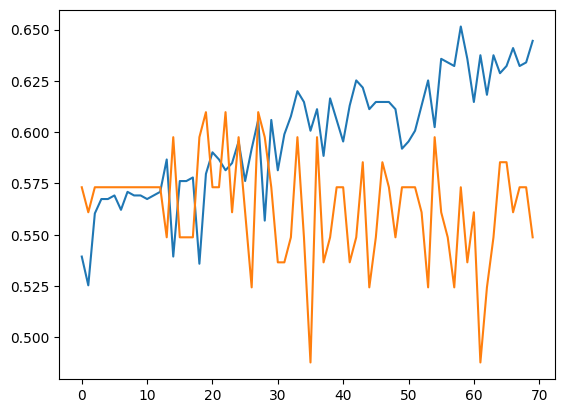

In [45]:
plt.plot(mlp.history['accuracy_train'])
plt.plot(mlp.history['accuracy_validation'])

In [71]:
def get_embeddings(data):
    embeddings = []
    for i, data in tqdm(enumerate(data)):
        datas = []
        for t in range(data.timesteps):

            temp = data.clone()
            for edge_type in temp.edge_types:
                if 'cls' in edge_type:
                    continue
                mask = temp[edge_type].time <= t
                temp[edge_type].edge_index = temp[edge_type].edge_index[:, mask]
            temp.step = t + 1
            temp.index = i
            datas.append(temp)
        
        for d in datas:
            add_cls_node(d)
        batch = pyg.data.Batch.from_data_list(datas).to(ttn.device)
        del datas
        x_dict = batch.x_dict
        edge_index_dict = batch.edge_index_dict

        # Apply temporal encoding to the node features
        for node_type in batch.node_types:

            if node_type == 'cls':
                continue

            _, counts = torch.unique(batch[node_type].batch, return_counts=True)
            timesteps = torch.cat([torch.arange(count) for count in counts]).to(ttn.device)

            temporal_features = ttn.TE(timesteps)
            x_dict[node_type][:, :770] += temporal_features


        with torch.no_grad():
            e = ttn.GNN(x_dict, edge_index_dict)
            embeddings.append(e['cls'].to(torch.device('cpu')))
    
    return embeddings

In [72]:
train_emb = get_embeddings(data_train)
test_emb = get_embeddings(data_test)
val_emb = get_embeddings(data_val)

571it [00:16, 33.75it/s]
164it [00:06, 25.95it/s]
82it [00:02, 29.97it/s]


In [73]:
x_train = torch.stack([torch.cat([emb[-1:, ], d['tweet'].x[0, :].unsqueeze(dim=1).t()], dim=1) for emb, d in zip(train_emb, data_train)]).squeeze(dim=1)
x_val = torch.stack([torch.cat([emb[-1:, ], d['tweet'].x[0, :].unsqueeze(dim=1).t()], dim=1) for emb, d in zip(val_emb, data_val)]).squeeze(dim=1)
x_test = torch.stack([torch.cat([emb[-1:, ], d['tweet'].x[0, :].unsqueeze(dim=1).t()], dim=1) for emb, d in zip(test_emb, data_test)]).squeeze(dim=1)

In [74]:
for i, emb in enumerate(train_emb):
    train_emb[i] = torch.cat(
        [
            emb, 
            data_train[i]['tweet'].x[0].repeat(emb.size(0), 1)
        ], dim=1
    )
for i, emb in enumerate(val_emb):
    val_emb[i] = torch.cat(
        [
            emb, 
            data_val[i]['tweet'].x[0].repeat(emb.size(0), 1)
        ], dim=1
    )

for i, emb in enumerate(test_emb):
    test_emb[i] = torch.cat(
        [
            emb, 
            data_test[i]['tweet'].x[0].repeat(emb.size(0), 1)
        ], dim=1
    )

In [75]:
device = torch.device('cuda')
mlp = MLP(
    [
        torch.nn.Linear(790, 512),
        # torch.nn.InstanceNorm1d(512),
        torch.nn.GELU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(512, 512),
        # torch.nn.InstanceNorm1d(512),
        torch.nn.GELU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(512, 256),
        # torch.nn.InstanceNorm1d(256),
        torch.nn.GELU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(256, 128),
        # torch.nn.InstanceNorm1d(128),
        torch.nn.GELU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(128, 64),
        # torch.nn.InstanceNorm1d(64),
        torch.nn.GELU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(64, 2)
    ],
    device=torch.device('cuda'),
    activation=torch.nn.LogSoftmax()
)
enet = EarlyNet(mlp=mlp, device=device)

TypeError: EarlyNet.__init__() missing 1 required positional argument: 'gnn'

In [76]:
enet.fit(data_train=(train_emb, torch.tensor(y_train)), data_validation=(val_emb, torch.tensor(y_val)), epochs=60)

/tmp/ipykernel_427180/3696798261.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enet.fit(data_train=(train_emb, torch.tensor(y_train)), data_validation=(val_emb, torch.tensor(y_val)), epochs=60)
Epoch 001/60 - Training Loss : 1.0105 - Training ACC : 0.5896 - Time Score : 0.2622: 100%|██████████| 18/18 [00:01<00:00, 13.72it/s]


              Val      Loss : 0.7917 - Val ACC : 0.7384 -  Time Score : 0.2869


Epoch 002/60 - Training Loss : 0.8745 - Training ACC : 0.7224 - Time Score : 0.2733: 100%|██████████| 18/18 [00:01<00:00, 15.15it/s]


              Val      Loss : 0.6497 - Val ACC : 0.7778 -  Time Score : 0.3778


Epoch 003/60 - Training Loss : 0.8244 - Training ACC : 0.7425 - Time Score : 0.2864: 100%|██████████| 18/18 [00:01<00:00, 13.92it/s]


              Val      Loss : 0.6084 - Val ACC : 0.7720 -  Time Score : 0.3618


Epoch 004/60 - Training Loss : 0.8057 - Training ACC : 0.7566 - Time Score : 0.3040: 100%|██████████| 18/18 [00:01<00:00, 14.54it/s]


              Val      Loss : 0.5934 - Val ACC : 0.8275 -  Time Score : 0.3403


Epoch 005/60 - Training Loss : 0.7791 - Training ACC : 0.7544 - Time Score : 0.2991: 100%|██████████| 18/18 [00:01<00:00, 14.56it/s]


              Val      Loss : 0.5584 - Val ACC : 0.8275 -  Time Score : 0.3527


Epoch 006/60 - Training Loss : 0.7669 - Training ACC : 0.7530 - Time Score : 0.2834: 100%|██████████| 18/18 [00:01<00:00, 14.25it/s]


              Val      Loss : 0.5487 - Val ACC : 0.8113 -  Time Score : 0.3721


Epoch 007/60 - Training Loss : 0.7503 - Training ACC : 0.7626 - Time Score : 0.2948: 100%|██████████| 18/18 [00:01<00:00, 14.54it/s]


              Val      Loss : 0.5371 - Val ACC : 0.8148 -  Time Score : 0.3359


Epoch 008/60 - Training Loss : 0.7412 - Training ACC : 0.7651 - Time Score : 0.2859: 100%|██████████| 18/18 [00:01<00:00, 13.39it/s]


              Val      Loss : 0.5499 - Val ACC : 0.8009 -  Time Score : 0.3624


Epoch 009/60 - Training Loss : 0.7320 - Training ACC : 0.7724 - Time Score : 0.2870: 100%|██████████| 18/18 [00:01<00:00, 14.11it/s]


              Val      Loss : 0.5447 - Val ACC : 0.7928 -  Time Score : 0.3370


Epoch 010/60 - Training Loss : 0.7178 - Training ACC : 0.7626 - Time Score : 0.2838: 100%|██████████| 18/18 [00:01<00:00, 14.43it/s]


              Val      Loss : 0.5260 - Val ACC : 0.7720 -  Time Score : 0.3426


Epoch 011/60 - Training Loss : 0.7071 - Training ACC : 0.7724 - Time Score : 0.2917: 100%|██████████| 18/18 [00:01<00:00, 14.72it/s]


              Val      Loss : 0.5112 - Val ACC : 0.8009 -  Time Score : 0.3385


Epoch 012/60 - Training Loss : 0.6951 - Training ACC : 0.7804 - Time Score : 0.2846: 100%|██████████| 18/18 [00:01<00:00, 14.96it/s]


              Val      Loss : 0.5180 - Val ACC : 0.7905 -  Time Score : 0.3613


Epoch 013/60 - Training Loss : 0.6893 - Training ACC : 0.7897 - Time Score : 0.2856: 100%|██████████| 18/18 [00:01<00:00, 14.37it/s]


              Val      Loss : 0.5130 - Val ACC : 0.7905 -  Time Score : 0.3847


Epoch 014/60 - Training Loss : 0.6744 - Training ACC : 0.7773 - Time Score : 0.2770: 100%|██████████| 18/18 [00:01<00:00, 14.81it/s]


              Val      Loss : 0.5232 - Val ACC : 0.7928 -  Time Score : 0.3436


Epoch 015/60 - Training Loss : 0.6627 - Training ACC : 0.7845 - Time Score : 0.2717: 100%|██████████| 18/18 [00:01<00:00, 15.00it/s]


              Val      Loss : 0.5282 - Val ACC : 0.8171 -  Time Score : 0.3618


Epoch 016/60 - Training Loss : 0.6644 - Training ACC : 0.7845 - Time Score : 0.2798: 100%|██████████| 18/18 [00:01<00:00, 13.05it/s]


              Val      Loss : 0.5129 - Val ACC : 0.7882 -  Time Score : 0.3459


Epoch 017/60 - Training Loss : 0.6486 - Training ACC : 0.7866 - Time Score : 0.2801: 100%|██████████| 18/18 [00:01<00:00, 14.41it/s]


              Val      Loss : 0.5527 - Val ACC : 0.8113 -  Time Score : 0.3488


Epoch 018/60 - Training Loss : 0.6403 - Training ACC : 0.7897 - Time Score : 0.2692: 100%|██████████| 18/18 [00:01<00:00, 14.01it/s]


              Val      Loss : 0.5327 - Val ACC : 0.7824 -  Time Score : 0.3468


Epoch 019/60 - Training Loss : 0.6361 - Training ACC : 0.7942 - Time Score : 0.2853: 100%|██████████| 18/18 [00:01<00:00, 13.80it/s]


              Val      Loss : 0.5006 - Val ACC : 0.7882 -  Time Score : 0.3294


Epoch 020/60 - Training Loss : 0.6183 - Training ACC : 0.8012 - Time Score : 0.2803: 100%|██████████| 18/18 [00:01<00:00, 13.39it/s]


              Val      Loss : 0.5100 - Val ACC : 0.7697 -  Time Score : 0.3865


Epoch 021/60 - Training Loss : 0.6122 - Training ACC : 0.8057 - Time Score : 0.2792: 100%|██████████| 18/18 [00:01<00:00, 13.21it/s]


              Val      Loss : 0.5378 - Val ACC : 0.7824 -  Time Score : 0.3364


Epoch 022/60 - Training Loss : 0.5958 - Training ACC : 0.8133 - Time Score : 0.2687: 100%|██████████| 18/18 [00:01<00:00, 13.55it/s]


              Val      Loss : 0.4926 - Val ACC : 0.7905 -  Time Score : 0.3738


Epoch 023/60 - Training Loss : 0.5894 - Training ACC : 0.8057 - Time Score : 0.2754: 100%|██████████| 18/18 [00:01<00:00, 13.76it/s]


              Val      Loss : 0.5121 - Val ACC : 0.7986 -  Time Score : 0.3320


Epoch 024/60 - Training Loss : 0.5744 - Training ACC : 0.8172 - Time Score : 0.2826: 100%|██████████| 18/18 [00:01<00:00, 13.27it/s]


              Val      Loss : 0.5361 - Val ACC : 0.7824 -  Time Score : 0.3707


Epoch 025/60 - Training Loss : 0.5690 - Training ACC : 0.8002 - Time Score : 0.2723: 100%|██████████| 18/18 [00:01<00:00, 13.95it/s]


              Val      Loss : 0.5690 - Val ACC : 0.7824 -  Time Score : 0.3509


Epoch 026/60 - Training Loss : 0.5570 - Training ACC : 0.8158 - Time Score : 0.2789: 100%|██████████| 18/18 [00:01<00:00, 14.12it/s]


              Val      Loss : 0.5451 - Val ACC : 0.7905 -  Time Score : 0.3330


Epoch 027/60 - Training Loss : 0.5515 - Training ACC : 0.8234 - Time Score : 0.2832: 100%|██████████| 18/18 [00:01<00:00, 15.22it/s]


              Val      Loss : 0.5671 - Val ACC : 0.7824 -  Time Score : 0.3769


Epoch 028/60 - Training Loss : 0.5259 - Training ACC : 0.8356 - Time Score : 0.2715: 100%|██████████| 18/18 [00:01<00:00, 13.83it/s]


              Val      Loss : 0.5758 - Val ACC : 0.7882 -  Time Score : 0.3430


Epoch 029/60 - Training Loss : 0.5155 - Training ACC : 0.8311 - Time Score : 0.2739: 100%|██████████| 18/18 [00:01<00:00, 14.34it/s]


              Val      Loss : 0.5889 - Val ACC : 0.7963 -  Time Score : 0.3283


Epoch 030/60 - Training Loss : 0.4967 - Training ACC : 0.8363 - Time Score : 0.2824: 100%|██████████| 18/18 [00:01<00:00, 13.18it/s]


              Val      Loss : 0.5569 - Val ACC : 0.7662 -  Time Score : 0.3760


Epoch 031/60 - Training Loss : 0.4821 - Training ACC : 0.8344 - Time Score : 0.2758: 100%|██████████| 18/18 [00:01<00:00, 14.59it/s]


              Val      Loss : 0.5702 - Val ACC : 0.7905 -  Time Score : 0.3374


Epoch 032/60 - Training Loss : 0.4645 - Training ACC : 0.8459 - Time Score : 0.2672: 100%|██████████| 18/18 [00:01<00:00, 16.53it/s]


              Val      Loss : 0.6543 - Val ACC : 0.7882 -  Time Score : 0.3298


Epoch 033/60 - Training Loss : 0.4538 - Training ACC : 0.8616 - Time Score : 0.2690: 100%|██████████| 18/18 [00:01<00:00, 15.03it/s]


              Val      Loss : 0.6132 - Val ACC : 0.7824 -  Time Score : 0.3360


Epoch 034/60 - Training Loss : 0.4361 - Training ACC : 0.8574 - Time Score : 0.2731: 100%|██████████| 18/18 [00:01<00:00, 14.74it/s]


              Val      Loss : 0.6567 - Val ACC : 0.7616 -  Time Score : 0.3753


Epoch 035/60 - Training Loss : 0.4365 - Training ACC : 0.8636 - Time Score : 0.2736: 100%|██████████| 18/18 [00:01<00:00, 14.64it/s]


              Val      Loss : 0.6387 - Val ACC : 0.7905 -  Time Score : 0.3410


Epoch 036/60 - Training Loss : 0.4054 - Training ACC : 0.8675 - Time Score : 0.2659: 100%|██████████| 18/18 [00:01<00:00, 14.21it/s]


              Val      Loss : 0.6753 - Val ACC : 0.7778 -  Time Score : 0.3533


Epoch 037/60 - Training Loss : 0.3986 - Training ACC : 0.8636 - Time Score : 0.2790: 100%|██████████| 18/18 [00:01<00:00, 14.54it/s]


              Val      Loss : 0.7705 - Val ACC : 0.7755 -  Time Score : 0.3654


Epoch 038/60 - Training Loss : 0.3763 - Training ACC : 0.8830 - Time Score : 0.2697: 100%|██████████| 18/18 [00:01<00:00, 14.23it/s]


              Val      Loss : 0.6634 - Val ACC : 0.7616 -  Time Score : 0.3536


Epoch 039/60 - Training Loss : 0.3411 - Training ACC : 0.8904 - Time Score : 0.2653: 100%|██████████| 18/18 [00:01<00:00, 13.66it/s]


              Val      Loss : 0.9298 - Val ACC : 0.7535 -  Time Score : 0.3785


Epoch 040/60 - Training Loss : 0.3597 - Training ACC : 0.8931 - Time Score : 0.2715: 100%|██████████| 18/18 [00:01<00:00, 14.40it/s]


              Val      Loss : 0.9106 - Val ACC : 0.7593 -  Time Score : 0.3816


Epoch 041/60 - Training Loss : 0.3240 - Training ACC : 0.8972 - Time Score : 0.2750: 100%|██████████| 18/18 [00:01<00:00, 13.57it/s]


              Val      Loss : 0.7513 - Val ACC : 0.7778 -  Time Score : 0.3656


Epoch 042/60 - Training Loss : 0.3165 - Training ACC : 0.8898 - Time Score : 0.2727: 100%|██████████| 18/18 [00:01<00:00, 13.02it/s]


              Val      Loss : 1.0595 - Val ACC : 0.7384 -  Time Score : 0.4400


Epoch 043/60 - Training Loss : 0.3080 - Training ACC : 0.8935 - Time Score : 0.2694: 100%|██████████| 18/18 [00:01<00:00, 13.11it/s]


              Val      Loss : 0.7612 - Val ACC : 0.7431 -  Time Score : 0.3193


Epoch 044/60 - Training Loss : 0.2865 - Training ACC : 0.8983 - Time Score : 0.2658: 100%|██████████| 18/18 [00:01<00:00, 14.26it/s]


              Val      Loss : 0.8300 - Val ACC : 0.7431 -  Time Score : 0.3495


Epoch 045/60 - Training Loss : 0.2921 - Training ACC : 0.8990 - Time Score : 0.2755: 100%|██████████| 18/18 [00:01<00:00, 14.43it/s]


              Val      Loss : 1.1128 - Val ACC : 0.7593 -  Time Score : 0.4346


Epoch 046/60 - Training Loss : 0.2766 - Training ACC : 0.9105 - Time Score : 0.2686: 100%|██████████| 18/18 [00:01<00:00, 14.31it/s]


              Val      Loss : 0.8283 - Val ACC : 0.7697 -  Time Score : 0.3596


Epoch 047/60 - Training Loss : 0.2440 - Training ACC : 0.9236 - Time Score : 0.2606: 100%|██████████| 18/18 [00:01<00:00, 13.77it/s]


              Val      Loss : 1.0013 - Val ACC : 0.7778 -  Time Score : 0.3852


Epoch 048/60 - Training Loss : 0.2513 - Training ACC : 0.9146 - Time Score : 0.2652: 100%|██████████| 18/18 [00:01<00:00, 14.30it/s]


              Val      Loss : 0.8887 - Val ACC : 0.7697 -  Time Score : 0.3467


Epoch 049/60 - Training Loss : 0.2538 - Training ACC : 0.9111 - Time Score : 0.2665: 100%|██████████| 18/18 [00:01<00:00, 14.04it/s]


              Val      Loss : 0.9681 - Val ACC : 0.7523 -  Time Score : 0.3863


Epoch 050/60 - Training Loss : 0.2170 - Training ACC : 0.9181 - Time Score : 0.2658: 100%|██████████| 18/18 [00:01<00:00, 14.10it/s]


              Val      Loss : 1.1124 - Val ACC : 0.7014 -  Time Score : 0.3948


Epoch 051/60 - Training Loss : 0.2339 - Training ACC : 0.9212 - Time Score : 0.2769: 100%|██████████| 18/18 [00:01<00:00, 14.03it/s]


              Val      Loss : 1.1012 - Val ACC : 0.7280 -  Time Score : 0.4068


Epoch 052/60 - Training Loss : 0.2198 - Training ACC : 0.9233 - Time Score : 0.2707: 100%|██████████| 18/18 [00:01<00:00, 13.99it/s]


              Val      Loss : 1.0652 - Val ACC : 0.7326 -  Time Score : 0.3375


Epoch 053/60 - Training Loss : 0.2005 - Training ACC : 0.9302 - Time Score : 0.2683: 100%|██████████| 18/18 [00:01<00:00, 14.44it/s]


              Val      Loss : 1.1626 - Val ACC : 0.7199 -  Time Score : 0.3858


Epoch 054/60 - Training Loss : 0.2022 - Training ACC : 0.9288 - Time Score : 0.2597: 100%|██████████| 18/18 [00:01<00:00, 14.02it/s]


              Val      Loss : 1.0522 - Val ACC : 0.7384 -  Time Score : 0.3618


Epoch 055/60 - Training Loss : 0.1720 - Training ACC : 0.9452 - Time Score : 0.2685: 100%|██████████| 18/18 [00:01<00:00, 14.75it/s]


              Val      Loss : 1.7607 - Val ACC : 0.5914 -  Time Score : 0.5866


Epoch 056/60 - Training Loss : 0.1896 - Training ACC : 0.9313 - Time Score : 0.2667: 100%|██████████| 18/18 [00:01<00:00, 13.86it/s]


              Val      Loss : 1.4170 - Val ACC : 0.7280 -  Time Score : 0.3694


Epoch 057/60 - Training Loss : 0.1597 - Training ACC : 0.9531 - Time Score : 0.2714: 100%|██████████| 18/18 [00:01<00:00, 14.73it/s]


              Val      Loss : 1.5232 - Val ACC : 0.6933 -  Time Score : 0.4011


Epoch 058/60 - Training Loss : 0.1625 - Training ACC : 0.9522 - Time Score : 0.2727: 100%|██████████| 18/18 [00:01<00:00, 15.03it/s]


              Val      Loss : 1.2918 - Val ACC : 0.7616 -  Time Score : 0.3743


Epoch 059/60 - Training Loss : 0.1643 - Training ACC : 0.9369 - Time Score : 0.2638: 100%|██████████| 18/18 [00:01<00:00, 15.26it/s]


              Val      Loss : 1.6129 - Val ACC : 0.6516 -  Time Score : 0.4668


Epoch 060/60 - Training Loss : 0.1341 - Training ACC : 0.9511 - Time Score : 0.2670: 100%|██████████| 18/18 [00:01<00:00, 15.23it/s]


              Val      Loss : 1.3433 - Val ACC : 0.7859 -  Time Score : 0.3614


In [77]:
pred = enet(x_test.to(device)).detach().cpu()

In [78]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
accuracy_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.6890243902439024

In [79]:
f1_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.746268656716418

In [80]:
roc_auc_score(y_test, pred.log_softmax(dim=1)[:, 1])

0.7192185370286235

In [46]:
device = torch.device('cuda')

In [49]:
class EarlyLoss(torch.nn.Module):
    def __init__(self, device):

        super(EarlyLoss, self).__init__()
        self.cross_entropy = torch.nn.CrossEntropyLoss(
            reduction='none'
        )
        self.device = device
    
    def forward(
        self,
        pred: torch.tensor,
        label: int
    ):
        
        
        steps = torch.arange(pred.size(0), dtype=torch.long, device=self.device) + 1
        labels = torch.ones(pred.size(0), dtype=torch.long,device=self.device) * label

        # steps = steps / steps.sum()
        steps = torch.log1p(steps)

        l_ce = self.cross_entropy(pred, labels) * steps
        l_time = 0

        time_score = 0
        logits = pred.softmax(dim=1).argmax(dim=1)

        pred = pred.softmax(dim=1)
        if label == 1:
            flag = True
            for idx, p in enumerate(logits):

                if p == 1:
                    time_score = (idx + 1) / len(logits)
                    l_time += torch.norm(pred[idx + 1:] - pred[idx], p=2)
                    flag = False
                    break
            if flag:
                time_score += pred.size(0)
            
        loss = 0.8 * (l_ce.mean()) + 0.2 * l_time
        
        return loss, time_score / pred.size(0)

In [48]:
class EarlyNet(torch.nn.Module):
    def __init__(
        self, 
        mlp: torch.nn.Module,
        device: torch.device
    ):

        super(EarlyNet, self).__init__()
        self.mlp = mlp
        self.device = device

        self.loss = EarlyLoss(device=device)
        self.optimizer = torch.optim.SGD(
            self.parameters(),
            lr=0.0005,
            # weight_decay=0.1
        )

        self.history = {
            'loss_train': [],
            'time_score_train': [],
            'accuracy_train': [],
            'loss_val': [],
            'time_score_val': [],
            'accuracy_val': [],
        }
    
    def forward(self, data):

        z = self.mlp(data)

        return z

    def train_step(self, data):

        self.train()
        X, Y = data

        loss = 0
        time_scores = 0

        self.optimizer.zero_grad()

        preds = []

        for x, y in zip(X, Y):

            x = x.to(self.device)
            y = y.to(self.device)

            pred = self(x)
            preds.append(pred[-1].detach().cpu())

            l, time_score = self.loss(pred, y)
            loss += l
            time_scores += time_score

        
    
        logits = torch.stack(preds).argmax(dim=1)
        
        loss.backward()
        self.optimizer.step()

        corrects = (logits == torch.stack(Y)).sum()
        acc = corrects / len(X)

        pos_count = (1 == torch.stack(Y)).sum()
        if pos_count > 0:
            time_scores = time_scores / pos_count
        else:
            time_score = 0

        return loss.item() / len(X), acc, time_scores
        

    def test_step(self, data):

        self.eval()
        X, Y = data

        loss = 0
        time_scores = 0
        preds = []

        with torch.no_grad():

            for x, y in zip(X, Y):

                x = x.to(self.device)
                y = y.to(self.device)

                pred = self(x)
                preds.append(pred[-1].detach().cpu())

                l, time_score = self.loss(pred, y)
                loss += l
                time_scores += time_score
        
        
        logits = torch.stack(preds).argmax(dim=1)
        corrects = (logits == torch.stack(Y)).sum()
        acc = corrects / len(X)

        pos_count = (1 == torch.stack(Y)).sum()
        if pos_count > 0:
            time_scores = time_scores / pos_count
        else:
            time_score = 0

        return loss.item() / len(X), acc, time_scores

    def fit(self, data_train, data_validation = None, epochs: int = 10):

        train_loader = torch.utils.data.DataLoader(
            list(zip(*data_train)), 
            batch_size=32, 
            collate_fn=lambda x: ([item[0] for item in x], [item[1] for item in x]), 
            shuffle=True
        )

        if data_validation:
            val_loader = torch.utils.data.DataLoader(
                list(zip(*data_validation)), 
                batch_size=32, 
                collate_fn=lambda x: ([item[0] for item in x], [item[1] for item in x]), 
                shuffle=True
            )
        

        for epoch in range(epochs):

            loss, acc, time_score = 0, 0, 0
            progbar = tqdm(
                train_loader,
                desc=''
            )
            for batch_idx, batch in enumerate(progbar):

                batch_loss, batch_acc, batch_time_score = self.train_step(data=batch)
                loss += batch_loss
                acc += batch_acc
                time_score += batch_time_score

                log = 'Epoch {:03d}/{} - Training Loss : {:.4f} - Training ACC : {:.4f} - Time Score : {:.4f}'.format(
                    epoch + 1,
                    epochs,
                    loss / (batch_idx + 1),
                    acc / (batch_idx + 1),
                    time_score / (batch_idx + 1)
                )

                progbar.set_description(log)
            
            self.history['loss_train'].append(loss / (batch_idx + 1))
            self.history['time_score_train'].append(time_score / (batch_idx + 1))
            self.history['accuracy_train'].append(acc / (batch_idx + 1))
            
            if data_validation:

                loss, acc, time_score = 0, 0, 0

                for batch_idx, batch in enumerate(val_loader):

                    batch_loss, batch_acc, batch_time_score = self.test_step(data=batch)
                    loss += batch_loss
                    acc += batch_acc
                    time_score += batch_time_score

                log_val = '              Val      Loss : {:.4f} - Val ACC : {:.4f} -  Time Score : {:.4f}'.format(
                    loss / (batch_idx + 1),
                    acc / (batch_idx + 1),
                    time_score / (batch_idx + 1)
                )

                self.history['loss_val'].append(loss / (batch_idx + 1))
                self.history['time_score_val'].append(time_score / (batch_idx + 1))
                self.history['accuracy_val'].append(acc / (batch_idx + 1))

                print(log_val)
                print(120 * '=')

In [190]:
torch.nn.GELU

torch.nn.modules.activation.GELU

In [246]:
mlp = MLP(
    [
        torch.nn.Linear(790, 512),
        torch.nn.InstanceNorm1d(512),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(512, 512),
        # torch.nn.InstanceNorm1d(512),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(512, 256),
        # torch.nn.InstanceNorm1d(256),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(256, 128),
        # torch.nn.InstanceNorm1d(128),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(128, 64),
        torch.nn.InstanceNorm1d(64),
        torch.nn.SiLU(),
        torch.nn.Dropout(p=0.3),

        torch.nn.Linear(64, 2)
    ],
    device=torch.device('cuda'),
    activation=torch.nn.Softmax()
)

In [247]:
device = torch.device('cuda')

In [248]:
enet = EarlyNet(mlp=mlp, device=device)

In [274]:
enet.fit(data_train=(train_emb, y_train), data_validation=(val_emb, y_val), epochs=5)

  0%|          | 0/18 [00:00<?, ?it/s]/home/ag/.local/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
Epoch 001/5 - Training Loss : 0.5456 - Training ACC : 0.8175 - Time Score : 0.2830: 100%|██████████| 18/18 [00:01<00:00, 12.35it/s]


              Val      Loss : 0.7949 - Val ACC : 0.6678 -  Time Score : 0.4468


Epoch 002/5 - Training Loss : 0.5260 - Training ACC : 0.8300 - Time Score : 0.2875: 100%|██████████| 18/18 [00:01<00:00, 12.55it/s]


              Val      Loss : 0.9772 - Val ACC : 0.5810 -  Time Score : 0.5253


Epoch 003/5 - Training Loss : 0.4813 - Training ACC : 0.8567 - Time Score : 0.2759: 100%|██████████| 18/18 [00:01<00:00, 12.00it/s]


              Val      Loss : 0.8185 - Val ACC : 0.6887 -  Time Score : 0.3965


Epoch 004/5 - Training Loss : 0.5298 - Training ACC : 0.8407 - Time Score : 0.2891: 100%|██████████| 18/18 [00:01<00:00, 13.20it/s]


              Val      Loss : 0.8079 - Val ACC : 0.6933 -  Time Score : 0.3728


Epoch 005/5 - Training Loss : 0.4423 - Training ACC : 0.8559 - Time Score : 0.2865: 100%|██████████| 18/18 [00:01<00:00, 12.72it/s]


              Val      Loss : 0.8983 - Val ACC : 0.7222 -  Time Score : 0.3362


In [275]:
pred = enet(x_test.to(device)).detach().cpu()

In [81]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score

In [276]:
accuracy_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.6463414634146342

In [191]:
accuracy_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.6524390243902439

In [128]:
accuracy_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.6646341463414634

In [523]:
accuracy_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.8108949416342413

In [277]:
accuracy_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.573170731707317

In [277]:
f1_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.7264150943396226

In [266]:
f1_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.7070707070707071

In [118]:
f1_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.6834170854271356

In [140]:
f1_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.7115384615384616

In [265]:
f1_score(y_test, pred.log_softmax(dim=1).argmax(dim=1))

0.7237354085603113

In [267]:
print(
    classification_report(
        y_test, pred.log_softmax(dim=1).argmax(dim=1)
    )
)

              precision    recall  f1-score   support

           0       0.61      0.51      0.55        71
           1       0.67      0.75      0.71        93

    accuracy                           0.65       164
   macro avg       0.64      0.63      0.63       164
weighted avg       0.64      0.65      0.64       164



In [278]:
roc_auc_score(y_test, pred.log_softmax(dim=1)[:, 1])

0.6863546872633651

In [505]:
roc_auc_score(y_test, pred.log_softmax(dim=1)[:, 1])

0.8848887163561076

In [517]:
roc_auc_score(y_test, pred.log_softmax(dim=1)[:, 1])

0.8809420289855072

In [525]:
roc_auc_score(y_test, pred.log_softmax(dim=1)[:, 1])

0.8815864389233954

In [534]:
roc_auc_score(y_test, pred.log_softmax(dim=1)[:, 1])

0.8793245341614907

In [138]:
for i, emb in enumerate(train_emb):
    train_emb[i] = torch.cat(
        [
            emb, 
            data_train[i]['tweet'].x[0].repeat(emb.size(0), 1)
        ], dim=1
    )
for i, emb in enumerate(val_emb):
    val_emb[i] = torch.cat(
        [
            emb, 
            data_val[i]['tweet'].x[0].repeat(emb.size(0), 1)
        ], dim=1
    )

for i, emb in enumerate(test_emb):
    test_emb[i] = torch.cat(
        [
            emb, 
            data_test[i]['tweet'].x[0].repeat(emb.size(0), 1)
        ], dim=1
    )

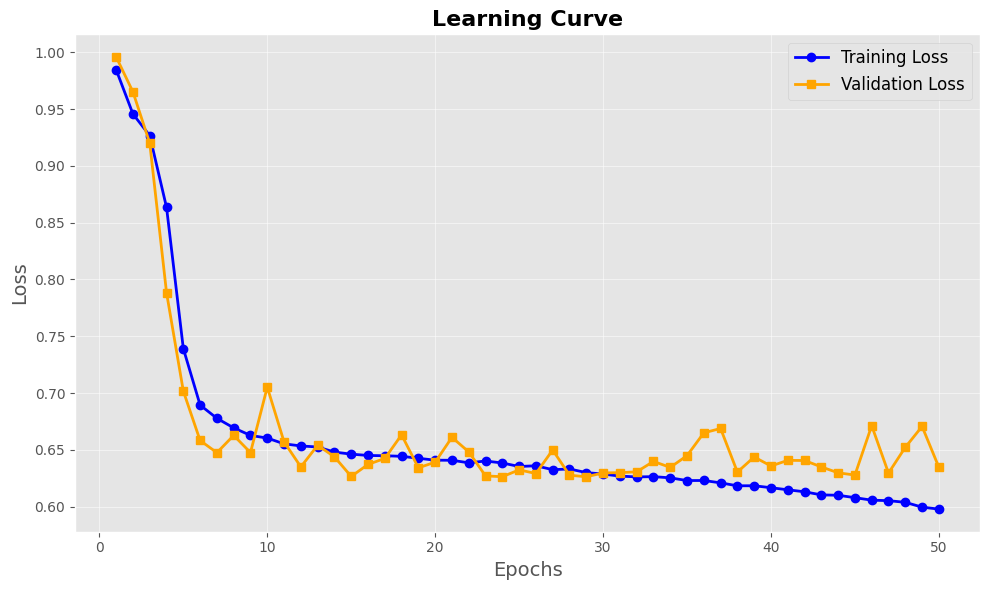

In [480]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(training_losses, validation_losses=None, title="Learning Curve"):
    plt.style.use("ggplot")
    plt.figure(figsize=(10, 6))

    epochs = np.arange(1, len(training_losses) + 1)
    plt.plot(epochs, training_losses, label="Training Loss", color="blue", linewidth=2, marker='o')

    if validation_losses is not None:
        plt.plot(epochs, validation_losses, label="Validation Loss", color="orange", linewidth=2, marker='s')

    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_learning_curve(enet.history['loss_train'][:50], enet.history['loss_val'][:50])


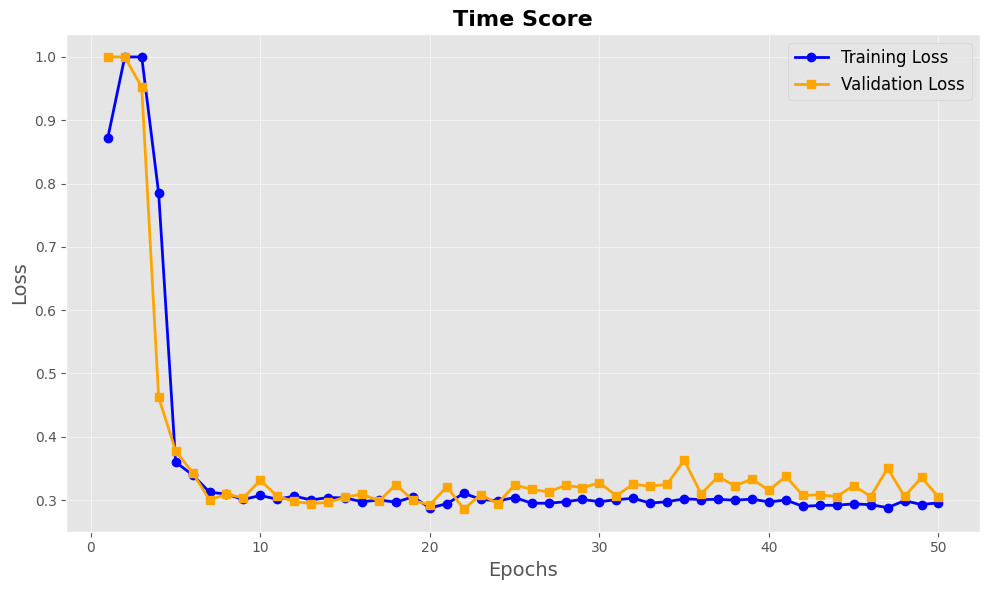

In [481]:
plot_learning_curve(enet.history['time_score_train'][:50], enet.history['time_score_val'][:50], title="Time Score")

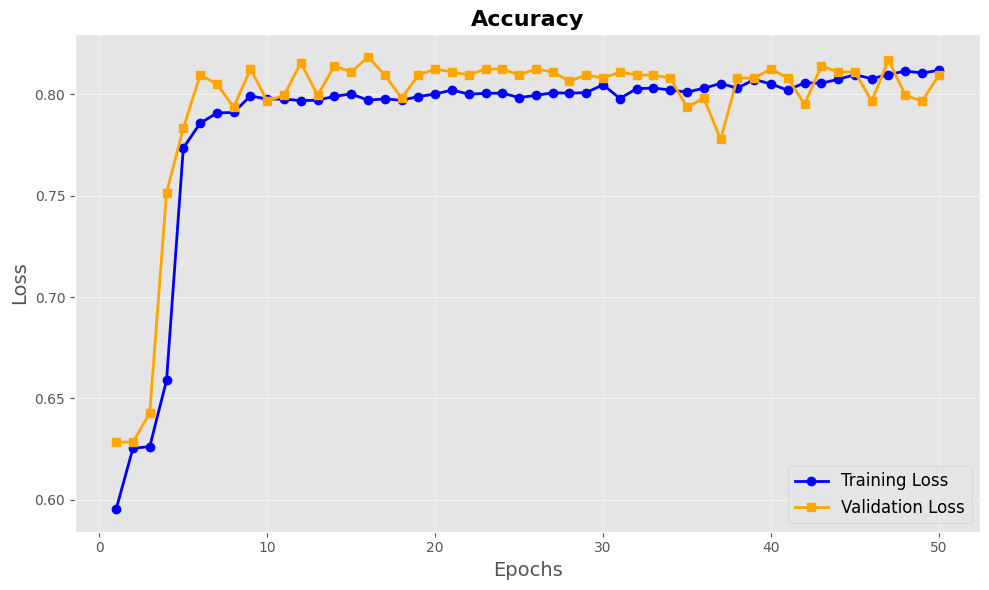

In [482]:
plot_learning_curve(enet.history['accuracy_train'][:50], enet.history['accuracy_val'][:50], title="Accuracy")

In [535]:
acc = [0.8116731517509728, 0.8054474708171206, 0.8015564202334631, 0.8108949416342413, 0.8085603112840467]

In [536]:
f1 = [0.7460815047021944, 0.7306034482758621, 0.7400611620795107, 0.7455497382198953, 0.7469135802469136]

In [537]:
roc = [0.8822541407867495, 0.8848887163561076, 0.8809420289855072, 0.8815864389233954, 0.8793245341614907]

In [541]:
acc

[0.8116731517509728,
 0.8054474708171206,
 0.8015564202334631,
 0.8108949416342413,
 0.8085603112840467]

In [539]:
print(np.mean(acc))

0.8076264591439688
